In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.models import alexnet
import torchvision.transforms as transforms

import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# --- Core Computational Utilities ---

def compute_spectral_norm(matrix):
    """
    Computes the spectral norm of a matrix.
    """
    
    return torch.linalg.matrix_norm(matrix, ord=2)

In [3]:
def compute_l21_norm(matrix):
    """
    Computes the L(2,1) norm of a matrix: L2 norm of columns, then L1 of the result.
    """
    return torch.sum(torch.linalg.norm(matrix, ord=2, dim=0))

In [4]:
# --- Main Calculation Engine ---

def compute_spectral_complexity(model: nn.Module):
    """
    Computes the spectral complexity R_A for a given PyTorch model.
    """
    product_terms = list()
    summation_terms = list()
    
    device = next(model.parameters()).device

    max_layer_time = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            print(f"Processing layer: {name} of type {type(module).__name__}")

            A_i = module.weight.data
            rho_i = 1.0  # Lipschitz constant for ReLU is 1
            
            start_time = time.perf_counter()

            if A_i.dim() == 4:
                A_i = A_i.view(A_i.size(0), -1)
            
            # 1. Compute spectral norm and product term
            s_i = compute_spectral_norm(A_i)
            
            
            
            # 2. Construct the reference matrix M_i
            M_i = torch.zeros_like(A_i)
            
            # 3. Compute the deviation term for the summation
            # Formula requires ||A_i^T - M_i^T||_{2,1}
            deviation_matrix_T = A_i.T - M_i.T
            deviation_norm = compute_l21_norm(deviation_matrix_T)
            

            # Add a small epsilon to avoid division by zero if spectral norm is 0
            # sum_term = (deviation_norm**(2/3)) / ((s_i + 1e-12)**(2/3))
            sum_term = (deviation_norm / s_i)**(2/3)
            end_time = time.perf_counter()

            max_layer_time = max(max_layer_time, end_time - start_time)
            # sum_term = (deviation_norm / s_i)**(2/3)
            summation_terms.append(sum_term)
            product_terms.append(rho_i * s_i)

    # Calculate the final components
    # Product term: prod(rho_i * ||A_i||_sigma)
    total_product = torch.prod(torch.stack(product_terms))
    
    # Summation term: (sum(...))^(3/2)
    total_sum = torch.sum(torch.stack(summation_terms))
    final_sum_term = total_sum**(3/2)
    
    # Final Spectral Complexity R_A
    R_A = total_product * final_sum_term

    print(f"Maximum Computation Time for Layer: {max_layer_time:.4f}s")
    
    return R_A, total_product, final_sum_term

In [5]:
def compute_gamma_distribution(model_path, train = False, subset_size = None):
    print("Loading pretrained 1CNN model...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        
    # Set the model to evaluation mode
    model.eval()
        
    # Compute the spectral complexity
    print("\nComputing spectral complexity...")
    start_time = time.perf_counter()
    spectral_complexity, product_component, sum_component = compute_spectral_complexity(model)
    end_time = time.perf_counter()
    print(f"Total Computation Time: {end_time - start_time:.4f}s")
        
    print("\n--- Results ---")
    print(f"Product Component (Lipschitz-like term): {product_component.item():.4e}")
    print(f"Summation Component (Structural Deviation term): {sum_component.item():.4e}")
    print(f"Total Spectral Complexity (R_A): {spectral_complexity.item():.4e}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) # Normalize with MNIST mean and std
    ])
    testset = torchvision.datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform)

    if subset_size is not None:
        total_size = len(testset)
        print(f"Testset size is: {total_size}")
        if subset_size < 1 and subset_size > 0:
            subset_size = int(subset_size * total_size)
        elif subset_size <= 0:
            raise ValueError("Sorry, negative numbers as subset_size are not allowed")
        else:
            subset_size = int(subset_size)
        remainder_size = total_size - subset_size
        
        # Randomly split the dataset
        generator = torch.Generator().manual_seed(42)
        testset, _ = torch.utils.data.random_split(testset, [subset_size, remainder_size], generator=generator)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    num_samples = len(testset)
    data_l2_norm = 0
    
    diffs = []
    
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # 1. Get the score corresponding to the target class
            # We use torch.arange to index the rows, and targets to index the columns
            batch_indices = torch.arange(inputs.size(0)).to(device)
            target_scores = outputs[batch_indices, targets]
            
            # 2. Find the max of non-target classes
            # Create a clone so we don't modify the original outputs
            outputs_without_target = outputs.clone()
            
            # Set the target indices to -infinity so they are never selected as max
            outputs_without_target[batch_indices, targets] = -float('inf')
            
            # Now taking the max gives us the highest score among the "wrong" classes
            max_others = torch.max(outputs_without_target, dim=1).values
            
            # 3. Calculate difference (Target - Max(Others))
            diffs.extend((target_scores - max_others).cpu().numpy())
            data_l2_norm += torch.sum(inputs**2)

    normal_diffs = np.array(diffs)/(spectral_complexity.item() * (torch.sqrt(data_l2_norm).item() / num_samples))

    return normal_diffs

    # return np.array(diffs)

In [8]:
overfit_train = compute_gamma_distribution("ckpt_1cnn_fmnist_overfit/epoch_1000.pth", True)
overfit_test = compute_gamma_distribution("ckpt_1cnn_fmnist_overfit/epoch_1000.pth", False)

Loading pretrained 1CNN model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: fc1 of type Linear
Maximum Computation Time for Layer: 0.0733s
Total Computation Time: 0.0828s

--- Results ---
Product Component (Lipschitz-like term): 6.6768e+03
Summation Component (Structural Deviation term): 2.5731e+01
Total Spectral Complexity (R_A): 1.7180e+05


Eval: 100%|██████████| 469/469 [00:12<00:00, 38.48it/s]


Loading pretrained 1CNN model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: fc1 of type Linear
Maximum Computation Time for Layer: 0.0005s
Total Computation Time: 0.0010s

--- Results ---
Product Component (Lipschitz-like term): 6.6768e+03
Summation Component (Structural Deviation term): 2.5731e+01
Total Spectral Complexity (R_A): 1.7180e+05


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.08it/s]


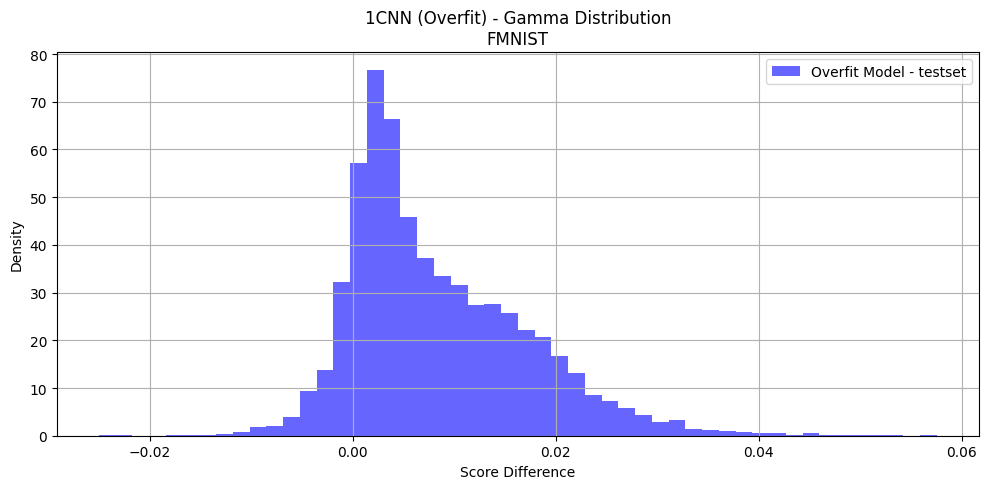

In [9]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(overfit_test, bins=50, alpha=0.6, label="Overfit Model - testset", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN (Overfit) - Gamma Distribution\nFMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

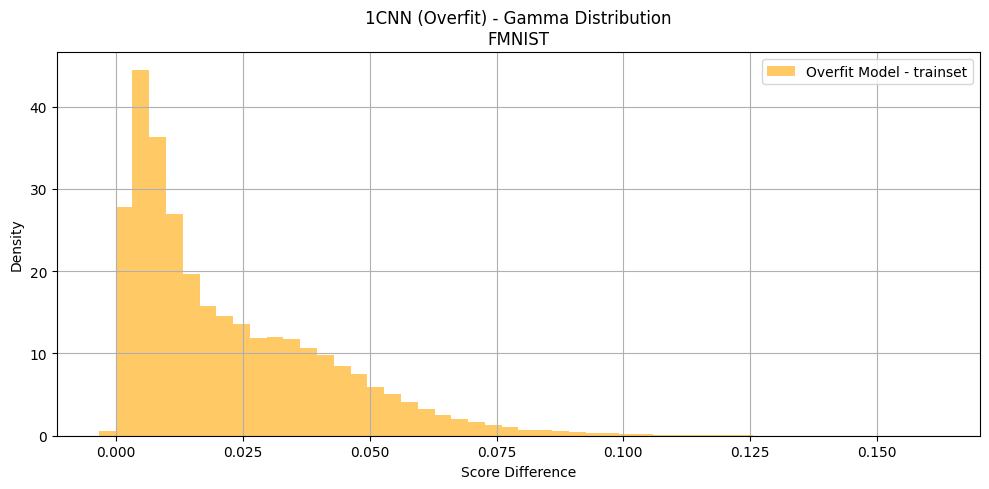

In [10]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit_train, bins=50, alpha=0.6, label="Overfit Model - trainset", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN (Overfit) - Gamma Distribution\nFMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

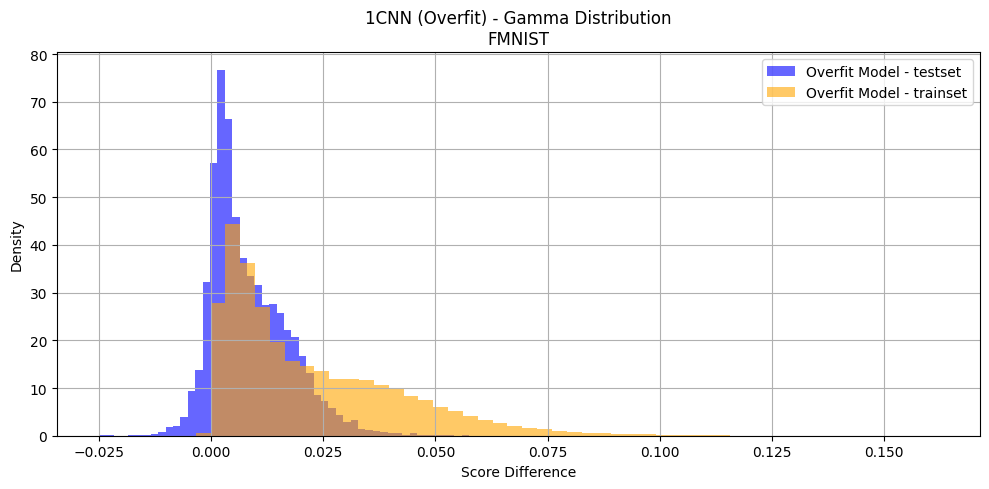

In [11]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(overfit_test, bins=50, alpha=0.6, label="Overfit Model - testset", color="blue", density=True)
plt.hist(overfit_train, bins=50, alpha=0.6, label="Overfit Model - trainset", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN (Overfit) - Gamma Distribution\nFMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_1cnn_fmnist_overfit.png")
plt.show()

In [12]:
correct_train = compute_gamma_distribution("ckpt_1cnn_fmnist/epoch_1000.pth", True)
correct_test = compute_gamma_distribution("ckpt_1cnn_fmnist/epoch_1000.pth", False)

Loading pretrained 1CNN model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: fc1 of type Linear
Maximum Computation Time for Layer: 0.0005s
Total Computation Time: 0.0010s

--- Results ---
Product Component (Lipschitz-like term): 1.5791e+01
Summation Component (Structural Deviation term): 2.4899e+01
Total Spectral Complexity (R_A): 3.9316e+02


Eval: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]


Loading pretrained 1CNN model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: fc1 of type Linear
Maximum Computation Time for Layer: 0.0005s
Total Computation Time: 0.0011s

--- Results ---
Product Component (Lipschitz-like term): 1.5791e+01
Summation Component (Structural Deviation term): 2.4899e+01
Total Spectral Complexity (R_A): 3.9316e+02


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.21it/s]


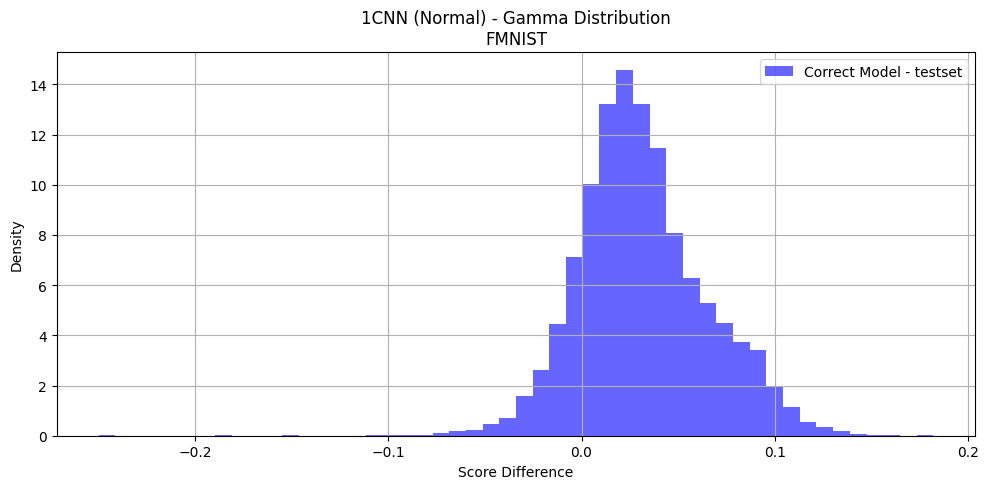

In [13]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct_test, bins=50, alpha=0.6, label="Correct Model - testset", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN (Normal) - Gamma Distribution\nFMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

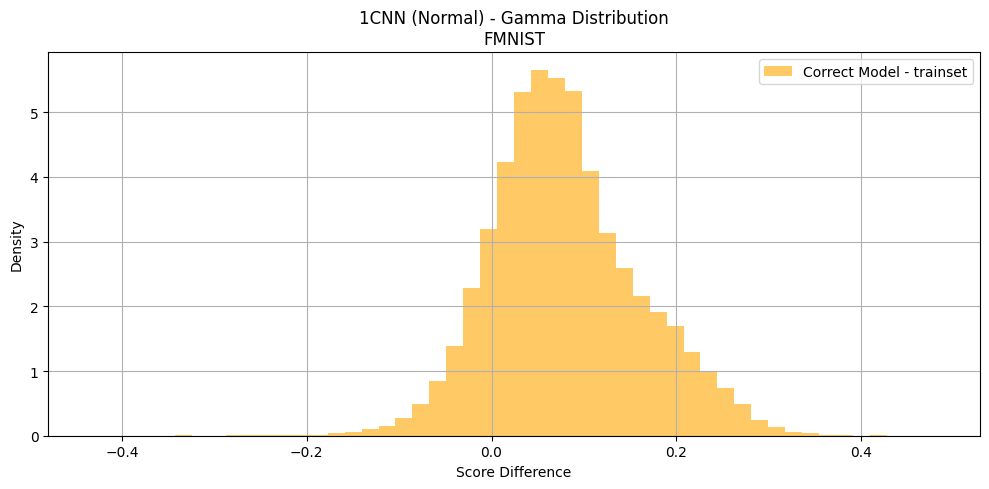

In [14]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(correct_train, bins=50, alpha=0.6, label="Correct Model - trainset", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN (Normal) - Gamma Distribution\nFMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

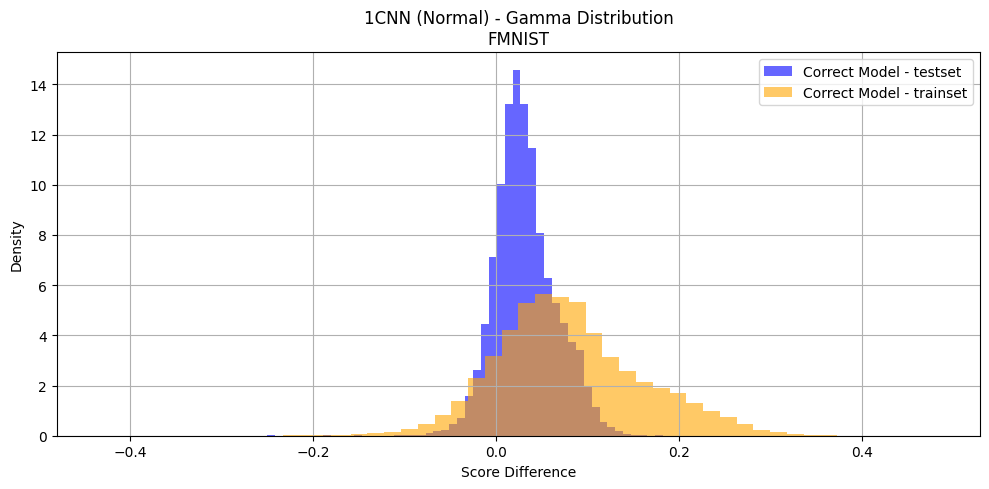

In [15]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct_test, bins=50, alpha=0.6, label="Correct Model - testset", color="blue", density=True)
plt.hist(correct_train, bins=50, alpha=0.6, label="Correct Model - trainset", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN (Normal) - Gamma Distribution\nFMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_1cnn_fmnist.png")
plt.show()

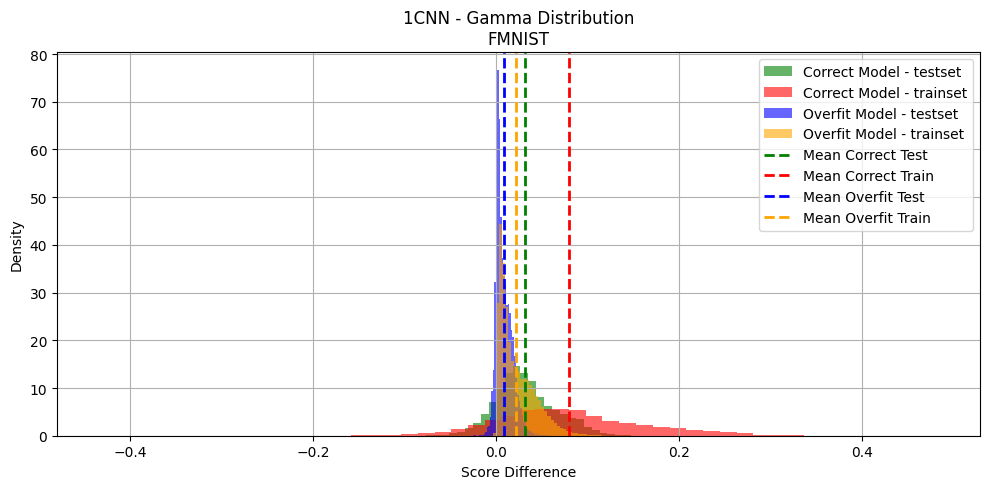

In [16]:
otr = np.mean(overfit_train)
ote = np.mean(overfit_test)
ctr = np.mean(correct_train)
cte = np.mean(correct_test)


plt.figure(figsize=(10, 5))
plt.hist(correct_test, bins=50, alpha=0.6, label="Correct Model - testset", color="green", density=True)
plt.hist(correct_train, bins=50, alpha=0.6, label="Correct Model - trainset", color="red", density=True)
plt.hist(overfit_test, bins=50, alpha=0.6, label="Overfit Model - testset", color="blue", density=True)
plt.hist(overfit_train, bins=50, alpha=0.6, label="Overfit Model - trainset", color="orange", density=True)

plt.axvline(cte, color='green', linestyle='dashed', linewidth=2, label='Mean Correct Test')
plt.axvline(ctr, color='red', linestyle='dashed', linewidth=2, label='Mean Correct Train')
plt.axvline(ote, color='blue', linestyle='dashed', linewidth=2, label='Mean Overfit Test')
plt.axvline(otr, color='orange', linestyle='dashed', linewidth=2, label='Mean Overfit Train')

plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN - Gamma Distribution\nFMNIST")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_1cnn_fmnist_all4.png")
plt.show()

In [7]:
subset_size = 512
overfit_test = compute_gamma_distribution("ckpt_1cnn_fmnist_overfit/epoch_1000.pth", False, subset_size)
correct_test = compute_gamma_distribution("ckpt_1cnn_fmnist/epoch_1000.pth", False, subset_size)

Loading pretrained 1CNN model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: fc1 of type Linear
Maximum Computation Time for Layer: 0.0103s
Total Computation Time: 0.0121s

--- Results ---
Product Component (Lipschitz-like term): 7.2031e+03
Summation Component (Structural Deviation term): 2.3885e+01
Total Spectral Complexity (R_A): 1.7204e+05
Testset size is: 10000


Eval: 100%|██████████| 4/4 [00:00<00:00, 15.17it/s]


Loading pretrained 1CNN model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: fc1 of type Linear
Maximum Computation Time for Layer: 0.0007s
Total Computation Time: 0.0011s

--- Results ---
Product Component (Lipschitz-like term): 1.5791e+01
Summation Component (Structural Deviation term): 2.4899e+01
Total Spectral Complexity (R_A): 3.9316e+02
Testset size is: 10000


Eval: 100%|██████████| 4/4 [00:00<00:00, 22.09it/s]


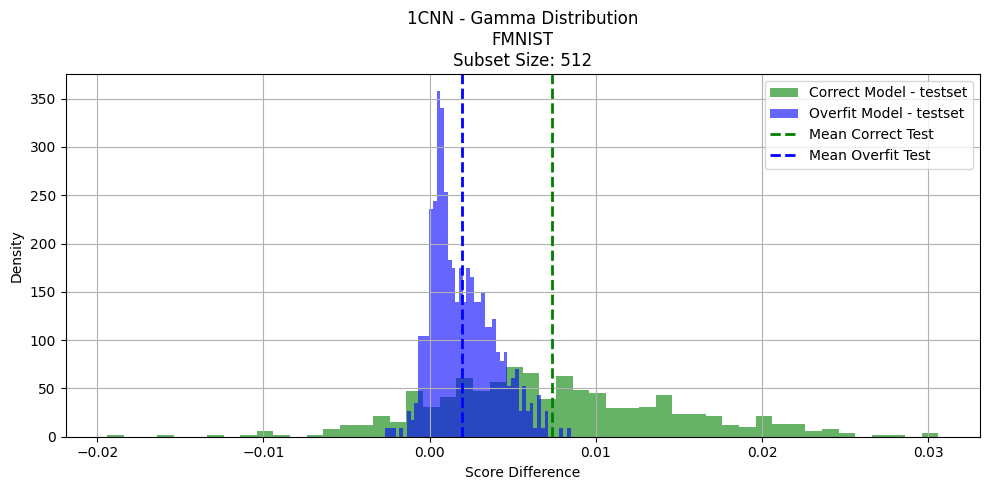

In [8]:
# print(type(overfit_train))
# otr = np.mean(overfit_train)
ote = overfit_test.mean()
# ctr = np.mean(correct_train)
cte = correct_test.mean()


plt.figure(figsize=(10, 5))
plt.hist(correct_test, bins=50, alpha=0.6, label="Correct Model - testset", color="green", density=True)
# plt.hist(correct_train, bins=50, alpha=0.6, label="Correct Model - trainset", color="red", density=True)
plt.hist(overfit_test, bins=50, alpha=0.6, label="Overfit Model - testset", color="blue", density=True)
# plt.hist(overfit_train, bins=50, alpha=0.6, label="Overfit Model - trainset", color="orange", density=True)

plt.axvline(cte, color='green', linestyle='dashed', linewidth=2, label='Mean Correct Test')
# plt.axvline(ctr, color='red', linestyle='dashed', linewidth=2, label='Mean Correct Train')
plt.axvline(ote, color='blue', linestyle='dashed', linewidth=2, label='Mean Overfit Test')
# plt.axvline(otr, color='orange', linestyle='dashed', linewidth=2, label='Mean Overfit Train')

plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"1CNN - Gamma Distribution\nFMNIST\nSubset Size: {subset_size}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"gamma_hist_1cnn_fmnist_subset_{subset_size}.png")
plt.show()

In [6]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize with MNIST mean and std
])

# Download and load the MNIST training and test datasets
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# total_size = len(train_dataset)
# subset_size = int(0.1 * total_size)
# remainder_size = total_size - subset_size

# # Randomly split the dataset
# train_dataset, _ = torch.utils.data.random_split(train_dataset, [subset_size, remainder_size])

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for batching and shuffling
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Convolutional Layer: 1 input channel (grayscale), 32 output channels
        # Kernel size 3x3, Padding 1 ensures output size matches input size before pooling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        
        # Max Pooling to reduce spatial dimensions (28x28 -> 14x14)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layer
        # Input size calculation: 32 channels * 14 height * 14 width = 6272
        self.fc1 = nn.Linear(32 * 14 * 14, 10) 
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # [Batch, 1, 28, 28] -> Conv -> ReLU -> Pool -> [Batch, 32, 14, 14]
        x = self.pool(self.relu(self.conv1(x)))
        
        # Flatten for the fully connected layer
        x = x.view(-1, 32 * 14 * 14)
        
        # [Batch, 6272] -> Linear -> [Batch, 10]
        x = self.fc1(x)
        return x

class FCN_MNIST(nn.Module):
    def __init__(self, input_size = 28 * 28, hidden_size = 128, num_classes = 10):
        super(FCN_MNIST, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                         # ReLU activation
        self.fc2 = nn.Linear(hidden_size, num_classes) # Output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN().to(device)
# model = FCN_MNIST().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Optional: Learning rate scheduler

epochs = 1000 # Adjust as needed

train_acc = list()
test_acc = list()
train_loss = list()
test_loss = list()

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    test_running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}, Train: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_acc_ = 100 * correct / total
    # scheduler.step() # If using a scheduler

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_acc_ = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {train_running_loss/len(trainloader):.4f}, train acc: {train_acc_:.2f}%, test acc: {test_acc_:.2f}%")
    train_acc.append(train_acc_)
    test_acc.append(test_acc_)
    train_loss.append(train_running_loss/len(trainloader))
    test_loss.append(test_running_loss/len(testloader))
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"ckpt_1cnn_fmnist_overfit/epoch_{epoch+1}.pth")

Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 1, Loss: 0.8159, train acc: 79.72%, test acc: 86.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 2, Loss: 0.3137, train acc: 88.95%, test acc: 87.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 3, Loss: 0.2759, train acc: 90.12%, test acc: 88.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 4, Loss: 0.2498, train acc: 91.12%, test acc: 89.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 5, Loss: 0.2288, train acc: 91.73%, test acc: 88.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 6, Loss: 0.2229, train acc: 92.00%, test acc: 90.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 7, Loss: 0.2015, train acc: 92.76%, test acc: 90.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 8, Loss: 0.1977, train acc: 92.88%, test acc: 89.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 9, Loss: 0.1847, train acc: 93.23%, test acc: 90.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


Epoch 10, Loss: 0.1745, train acc: 93.73%, test acc: 90.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 11, Loss: 0.1677, train acc: 93.91%, test acc: 89.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 12, Loss: 0.1660, train acc: 94.05%, test acc: 90.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 13, Loss: 0.1586, train acc: 94.27%, test acc: 90.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 14, Loss: 0.1508, train acc: 94.62%, test acc: 90.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 15, Loss: 0.1465, train acc: 94.62%, test acc: 90.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 16, Loss: 0.1345, train acc: 95.19%, test acc: 90.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 17, Loss: 0.1301, train acc: 95.31%, test acc: 89.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 18, Loss: 0.1295, train acc: 95.28%, test acc: 90.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 19, Loss: 0.1251, train acc: 95.53%, test acc: 89.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 20, Loss: 0.1268, train acc: 95.36%, test acc: 90.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 21, Loss: 0.1203, train acc: 95.58%, test acc: 89.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 22, Loss: 0.1147, train acc: 95.79%, test acc: 89.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 23, Loss: 0.1201, train acc: 95.56%, test acc: 90.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 24, Loss: 0.1058, train acc: 96.11%, test acc: 89.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 25, Loss: 0.1027, train acc: 96.21%, test acc: 88.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 26, Loss: 0.1054, train acc: 96.12%, test acc: 89.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 27, Loss: 0.1043, train acc: 96.11%, test acc: 90.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.12it/s]


Epoch 28, Loss: 0.0991, train acc: 96.32%, test acc: 90.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


Epoch 29, Loss: 0.1026, train acc: 96.20%, test acc: 89.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 30, Loss: 0.0923, train acc: 96.63%, test acc: 89.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 31, Loss: 0.0929, train acc: 96.58%, test acc: 89.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 32, Loss: 0.1014, train acc: 96.38%, test acc: 89.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 33, Loss: 0.0928, train acc: 96.60%, test acc: 89.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 34, Loss: 0.0922, train acc: 96.58%, test acc: 89.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 35, Loss: 0.0786, train acc: 97.06%, test acc: 89.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 36, Loss: 0.0883, train acc: 96.73%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 37, Loss: 0.0886, train acc: 96.75%, test acc: 89.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.09it/s]


Epoch 38, Loss: 0.0865, train acc: 96.82%, test acc: 88.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 39, Loss: 0.0974, train acc: 96.45%, test acc: 89.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.20it/s]


Epoch 40, Loss: 0.0821, train acc: 96.96%, test acc: 89.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 41, Loss: 0.0813, train acc: 97.00%, test acc: 89.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.12it/s]


Epoch 42, Loss: 0.0757, train acc: 97.25%, test acc: 89.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.10it/s]


Epoch 43, Loss: 0.0735, train acc: 97.26%, test acc: 89.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.16it/s]


Epoch 44, Loss: 0.0728, train acc: 97.31%, test acc: 89.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.07it/s]


Epoch 45, Loss: 0.0794, train acc: 97.04%, test acc: 88.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 46, Loss: 0.0831, train acc: 96.98%, test acc: 87.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 47, Loss: 0.0909, train acc: 96.74%, test acc: 89.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.14it/s]


Epoch 48, Loss: 0.0789, train acc: 97.11%, test acc: 89.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 49, Loss: 0.0758, train acc: 97.18%, test acc: 88.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.11it/s]


Epoch 50, Loss: 0.0662, train acc: 97.58%, test acc: 89.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 51, Loss: 0.0747, train acc: 97.19%, test acc: 89.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 52, Loss: 0.0645, train acc: 97.65%, test acc: 88.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 53, Loss: 0.0653, train acc: 97.58%, test acc: 89.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 54, Loss: 0.0665, train acc: 97.48%, test acc: 88.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 55, Loss: 0.0617, train acc: 97.70%, test acc: 89.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 56, Loss: 0.0576, train acc: 97.89%, test acc: 89.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 57, Loss: 0.0546, train acc: 98.01%, test acc: 89.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 58, Loss: 0.0683, train acc: 97.51%, test acc: 89.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 59, Loss: 0.0574, train acc: 97.85%, test acc: 88.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 60, Loss: 0.0645, train acc: 97.66%, test acc: 89.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.05it/s]


Epoch 61, Loss: 0.0754, train acc: 97.30%, test acc: 89.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 62, Loss: 0.0706, train acc: 97.48%, test acc: 88.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 63, Loss: 0.0650, train acc: 97.58%, test acc: 89.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 64, Loss: 0.0535, train acc: 98.03%, test acc: 88.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 65, Loss: 0.0598, train acc: 97.77%, test acc: 89.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 66, Loss: 0.0581, train acc: 97.91%, test acc: 88.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.06it/s]


Epoch 67, Loss: 0.0536, train acc: 98.08%, test acc: 89.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.08it/s]


Epoch 68, Loss: 0.0515, train acc: 98.14%, test acc: 88.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.11it/s]


Epoch 69, Loss: 0.0524, train acc: 98.12%, test acc: 88.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 70, Loss: 0.0589, train acc: 97.88%, test acc: 88.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.08it/s]


Epoch 71, Loss: 0.0572, train acc: 97.92%, test acc: 88.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 72, Loss: 0.0562, train acc: 97.97%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.03it/s]


Epoch 73, Loss: 0.0542, train acc: 98.04%, test acc: 88.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 74, Loss: 0.0451, train acc: 98.34%, test acc: 89.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 75, Loss: 0.0364, train acc: 98.66%, test acc: 88.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 76, Loss: 0.0436, train acc: 98.42%, test acc: 89.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 77, Loss: 0.0482, train acc: 98.24%, test acc: 88.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 78, Loss: 0.0692, train acc: 97.65%, test acc: 88.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


Epoch 79, Loss: 0.0668, train acc: 97.74%, test acc: 88.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 80, Loss: 0.0589, train acc: 97.93%, test acc: 88.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 81, Loss: 0.0602, train acc: 97.88%, test acc: 87.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 82, Loss: 0.0732, train acc: 97.57%, test acc: 88.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 83, Loss: 0.0441, train acc: 98.36%, test acc: 88.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 84, Loss: 0.0510, train acc: 98.22%, test acc: 88.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 85, Loss: 0.0509, train acc: 98.24%, test acc: 88.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 86, Loss: 0.0403, train acc: 98.53%, test acc: 88.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 87, Loss: 0.0386, train acc: 98.59%, test acc: 88.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 88, Loss: 0.0410, train acc: 98.49%, test acc: 88.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 89, Loss: 0.0417, train acc: 98.48%, test acc: 88.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 90, Loss: 0.0448, train acc: 98.41%, test acc: 88.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 91, Loss: 0.0496, train acc: 98.25%, test acc: 88.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 92, Loss: 0.0451, train acc: 98.41%, test acc: 88.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 93, Loss: 0.0386, train acc: 98.69%, test acc: 88.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 94, Loss: 0.0661, train acc: 97.92%, test acc: 88.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 95, Loss: 0.0667, train acc: 97.82%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 96, Loss: 0.0509, train acc: 98.26%, test acc: 88.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 97, Loss: 0.0398, train acc: 98.60%, test acc: 88.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 98, Loss: 0.0309, train acc: 98.84%, test acc: 88.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 99, Loss: 0.0367, train acc: 98.73%, test acc: 88.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 100, Loss: 0.0557, train acc: 98.17%, test acc: 88.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 101, Loss: 0.0659, train acc: 97.88%, test acc: 88.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 102, Loss: 0.0437, train acc: 98.44%, test acc: 88.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 103, Loss: 0.0327, train acc: 98.87%, test acc: 87.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 104, Loss: 0.0347, train acc: 98.79%, test acc: 88.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 105, Loss: 0.0264, train acc: 99.05%, test acc: 88.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 106, Loss: 0.0299, train acc: 98.92%, test acc: 88.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 107, Loss: 0.0385, train acc: 98.67%, test acc: 88.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.03it/s]


Epoch 108, Loss: 0.0369, train acc: 98.70%, test acc: 88.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 109, Loss: 0.0349, train acc: 98.78%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 110, Loss: 0.0572, train acc: 98.14%, test acc: 88.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 111, Loss: 0.0398, train acc: 98.58%, test acc: 88.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 112, Loss: 0.0501, train acc: 98.39%, test acc: 88.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 113, Loss: 0.0371, train acc: 98.77%, test acc: 88.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.08it/s]


Epoch 114, Loss: 0.0326, train acc: 98.83%, test acc: 87.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 115, Loss: 0.0387, train acc: 98.62%, test acc: 88.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 116, Loss: 0.0480, train acc: 98.36%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 117, Loss: 0.0421, train acc: 98.61%, test acc: 88.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 118, Loss: 0.0361, train acc: 98.70%, test acc: 88.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 119, Loss: 0.0289, train acc: 98.99%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 120, Loss: 0.0459, train acc: 98.48%, test acc: 88.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 121, Loss: 0.0564, train acc: 98.22%, test acc: 87.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 122, Loss: 0.0488, train acc: 98.37%, test acc: 88.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 123, Loss: 0.0383, train acc: 98.73%, test acc: 88.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 124, Loss: 0.0331, train acc: 98.85%, test acc: 88.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 125, Loss: 0.0289, train acc: 98.97%, test acc: 88.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 126, Loss: 0.0307, train acc: 98.94%, test acc: 88.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 127, Loss: 0.0493, train acc: 98.45%, test acc: 88.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 128, Loss: 0.0335, train acc: 98.98%, test acc: 88.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 129, Loss: 0.0407, train acc: 98.71%, test acc: 88.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 130, Loss: 0.0463, train acc: 98.46%, test acc: 87.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 131, Loss: 0.0383, train acc: 98.75%, test acc: 87.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.03it/s]


Epoch 132, Loss: 0.0316, train acc: 98.88%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 133, Loss: 0.0220, train acc: 99.19%, test acc: 88.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 134, Loss: 0.0194, train acc: 99.31%, test acc: 88.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 135, Loss: 0.0229, train acc: 99.16%, test acc: 88.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 136, Loss: 0.0491, train acc: 98.53%, test acc: 88.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 137, Loss: 0.0416, train acc: 98.65%, test acc: 88.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 138, Loss: 0.0346, train acc: 98.86%, test acc: 88.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 139, Loss: 0.0380, train acc: 98.77%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 140, Loss: 0.0464, train acc: 98.57%, test acc: 88.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 141, Loss: 0.0399, train acc: 98.70%, test acc: 88.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 142, Loss: 0.0305, train acc: 98.96%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 143, Loss: 0.0248, train acc: 99.11%, test acc: 88.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 144, Loss: 0.0311, train acc: 99.01%, test acc: 88.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 145, Loss: 0.0409, train acc: 98.80%, test acc: 87.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 146, Loss: 0.0513, train acc: 98.47%, test acc: 88.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 147, Loss: 0.0318, train acc: 98.92%, test acc: 88.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 148, Loss: 0.0261, train acc: 99.13%, test acc: 88.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 149, Loss: 0.0362, train acc: 98.79%, test acc: 88.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 150, Loss: 0.0222, train acc: 99.23%, test acc: 88.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 151, Loss: 0.0307, train acc: 98.95%, test acc: 88.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 152, Loss: 0.0378, train acc: 98.81%, test acc: 88.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 153, Loss: 0.0465, train acc: 98.68%, test acc: 87.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 154, Loss: 0.0619, train acc: 98.38%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 155, Loss: 0.0355, train acc: 98.82%, test acc: 88.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 156, Loss: 0.0247, train acc: 99.15%, test acc: 88.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 157, Loss: 0.0213, train acc: 99.22%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 158, Loss: 0.0360, train acc: 98.90%, test acc: 88.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.03it/s]


Epoch 159, Loss: 0.0184, train acc: 99.36%, test acc: 88.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 160, Loss: 0.0175, train acc: 99.38%, test acc: 88.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 161, Loss: 0.0199, train acc: 99.36%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 162, Loss: 0.0507, train acc: 98.50%, test acc: 87.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 163, Loss: 0.0385, train acc: 98.79%, test acc: 88.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 164, Loss: 0.0403, train acc: 98.77%, test acc: 87.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 165, Loss: 0.0434, train acc: 98.72%, test acc: 88.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 166, Loss: 0.0448, train acc: 98.70%, test acc: 88.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 167, Loss: 0.0304, train acc: 99.00%, test acc: 88.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 168, Loss: 0.0250, train acc: 99.25%, test acc: 88.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 169, Loss: 0.0453, train acc: 98.72%, test acc: 88.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 170, Loss: 0.0223, train acc: 99.26%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 171, Loss: 0.0502, train acc: 98.60%, test acc: 88.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 172, Loss: 0.0362, train acc: 98.94%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 173, Loss: 0.0361, train acc: 98.91%, test acc: 88.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 174, Loss: 0.0365, train acc: 98.89%, test acc: 88.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 175, Loss: 0.0273, train acc: 99.19%, test acc: 88.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 176, Loss: 0.0296, train acc: 99.09%, test acc: 88.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 177, Loss: 0.0186, train acc: 99.36%, test acc: 88.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 178, Loss: 0.0186, train acc: 99.40%, test acc: 87.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 179, Loss: 0.0334, train acc: 99.01%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 180, Loss: 0.0289, train acc: 99.08%, test acc: 87.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 181, Loss: 0.0281, train acc: 99.12%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 182, Loss: 0.0325, train acc: 99.00%, test acc: 88.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 183, Loss: 0.0244, train acc: 99.22%, test acc: 87.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 184, Loss: 0.0181, train acc: 99.33%, test acc: 88.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 185, Loss: 0.0303, train acc: 99.04%, test acc: 88.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 186, Loss: 0.0513, train acc: 98.62%, test acc: 88.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 187, Loss: 0.0648, train acc: 98.42%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 188, Loss: 0.0321, train acc: 99.08%, test acc: 88.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 189, Loss: 0.0189, train acc: 99.35%, test acc: 88.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 190, Loss: 0.0231, train acc: 99.30%, test acc: 88.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 191, Loss: 0.0159, train acc: 99.51%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 192, Loss: 0.0208, train acc: 99.34%, test acc: 88.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 193, Loss: 0.0540, train acc: 98.54%, test acc: 87.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 194, Loss: 0.0385, train acc: 98.93%, test acc: 88.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 195, Loss: 0.0254, train acc: 99.18%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 196, Loss: 0.0224, train acc: 99.28%, test acc: 87.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 197, Loss: 0.0177, train acc: 99.43%, test acc: 87.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 198, Loss: 0.0200, train acc: 99.44%, test acc: 88.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 199, Loss: 0.0325, train acc: 99.06%, test acc: 88.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 200, Loss: 0.0169, train acc: 99.40%, test acc: 88.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 201, Loss: 0.0222, train acc: 99.33%, test acc: 88.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 202, Loss: 0.0657, train acc: 98.41%, test acc: 88.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 203, Loss: 0.0319, train acc: 99.05%, test acc: 88.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


Epoch 204, Loss: 0.0415, train acc: 98.92%, test acc: 87.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 205, Loss: 0.0377, train acc: 98.92%, test acc: 88.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 206, Loss: 0.0229, train acc: 99.31%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 207, Loss: 0.0169, train acc: 99.47%, test acc: 88.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 208, Loss: 0.0177, train acc: 99.41%, test acc: 88.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 209, Loss: 0.0226, train acc: 99.30%, test acc: 87.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 210, Loss: 0.0571, train acc: 98.58%, test acc: 87.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 211, Loss: 0.0371, train acc: 98.93%, test acc: 87.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 212, Loss: 0.0289, train acc: 99.15%, test acc: 88.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 213, Loss: 0.0318, train acc: 99.07%, test acc: 87.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 214, Loss: 0.0543, train acc: 98.68%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 215, Loss: 0.0262, train acc: 99.19%, test acc: 88.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 216, Loss: 0.0200, train acc: 99.36%, test acc: 88.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 217, Loss: 0.0190, train acc: 99.39%, test acc: 88.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 218, Loss: 0.0166, train acc: 99.42%, test acc: 88.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 219, Loss: 0.0237, train acc: 99.29%, test acc: 88.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 220, Loss: 0.0121, train acc: 99.60%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 221, Loss: 0.0220, train acc: 99.35%, test acc: 88.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 222, Loss: 0.0595, train acc: 98.65%, test acc: 87.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 223, Loss: 0.0466, train acc: 98.86%, test acc: 88.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.03it/s]


Epoch 224, Loss: 0.0265, train acc: 99.24%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 225, Loss: 0.0154, train acc: 99.52%, test acc: 88.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 226, Loss: 0.0286, train acc: 99.23%, test acc: 88.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 227, Loss: 0.0317, train acc: 99.14%, test acc: 88.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 228, Loss: 0.0226, train acc: 99.32%, test acc: 87.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 229, Loss: 0.0275, train acc: 99.19%, test acc: 88.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 230, Loss: 0.0338, train acc: 99.10%, test acc: 87.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 231, Loss: 0.0345, train acc: 99.02%, test acc: 87.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 232, Loss: 0.0186, train acc: 99.41%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 233, Loss: 0.0110, train acc: 99.63%, test acc: 88.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 234, Loss: 0.0232, train acc: 99.28%, test acc: 87.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 235, Loss: 0.0237, train acc: 99.29%, test acc: 87.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 236, Loss: 0.0280, train acc: 99.23%, test acc: 88.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 237, Loss: 0.0328, train acc: 99.10%, test acc: 88.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 238, Loss: 0.0372, train acc: 99.09%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 239, Loss: 0.0338, train acc: 99.10%, test acc: 88.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 240, Loss: 0.0547, train acc: 98.70%, test acc: 87.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.11it/s]


Epoch 241, Loss: 0.0322, train acc: 99.14%, test acc: 88.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 242, Loss: 0.0303, train acc: 99.22%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 248, Loss: 0.0263, train acc: 99.26%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 249, Loss: 0.0171, train acc: 99.46%, test acc: 88.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 250, Loss: 0.0235, train acc: 99.39%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 251, Loss: 0.0495, train acc: 98.83%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 252, Loss: 0.0321, train acc: 99.17%, test acc: 88.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 253, Loss: 0.0168, train acc: 99.49%, test acc: 88.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 254, Loss: 0.0401, train acc: 99.01%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 255, Loss: 0.0163, train acc: 99.51%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 256, Loss: 0.0142, train acc: 99.57%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 257, Loss: 0.0121, train acc: 99.63%, test acc: 88.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 258, Loss: 0.0261, train acc: 99.27%, test acc: 88.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 259, Loss: 0.0336, train acc: 99.09%, test acc: 87.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 260, Loss: 0.0247, train acc: 99.30%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 261, Loss: 0.0239, train acc: 99.28%, test acc: 88.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 262, Loss: 0.0249, train acc: 99.33%, test acc: 88.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 263, Loss: 0.0540, train acc: 98.86%, test acc: 87.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 264, Loss: 0.0229, train acc: 99.38%, test acc: 88.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 265, Loss: 0.0137, train acc: 99.59%, test acc: 87.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 266, Loss: 0.0390, train acc: 99.03%, test acc: 87.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 267, Loss: 0.0533, train acc: 98.82%, test acc: 87.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 268, Loss: 0.0323, train acc: 99.24%, test acc: 88.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 269, Loss: 0.0297, train acc: 99.22%, test acc: 87.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 270, Loss: 0.0270, train acc: 99.37%, test acc: 88.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 271, Loss: 0.0269, train acc: 99.33%, test acc: 88.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 272, Loss: 0.0171, train acc: 99.50%, test acc: 87.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 273, Loss: 0.0185, train acc: 99.47%, test acc: 88.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 274, Loss: 0.0194, train acc: 99.46%, test acc: 88.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 275, Loss: 0.0384, train acc: 99.07%, test acc: 87.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 276, Loss: 0.0204, train acc: 99.47%, test acc: 88.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 277, Loss: 0.0409, train acc: 99.00%, test acc: 88.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 278, Loss: 0.0218, train acc: 99.36%, test acc: 88.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 279, Loss: 0.0269, train acc: 99.32%, test acc: 87.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 280, Loss: 0.0393, train acc: 99.10%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 281, Loss: 0.0178, train acc: 99.51%, test acc: 88.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 282, Loss: 0.0098, train acc: 99.68%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 283, Loss: 0.0131, train acc: 99.64%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 284, Loss: 0.0262, train acc: 99.31%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 285, Loss: 0.0211, train acc: 99.39%, test acc: 87.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 286, Loss: 0.0330, train acc: 99.17%, test acc: 87.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 287, Loss: 0.0347, train acc: 99.18%, test acc: 88.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 288, Loss: 0.0328, train acc: 99.15%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 289, Loss: 0.0179, train acc: 99.48%, test acc: 88.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 290, Loss: 0.0153, train acc: 99.60%, test acc: 87.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 291, Loss: 0.0607, train acc: 98.76%, test acc: 88.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 292, Loss: 0.0542, train acc: 98.82%, test acc: 87.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 293, Loss: 0.0402, train acc: 99.05%, test acc: 88.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 294, Loss: 0.0214, train acc: 99.43%, test acc: 87.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 295, Loss: 0.0177, train acc: 99.54%, test acc: 88.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 296, Loss: 0.0120, train acc: 99.63%, test acc: 88.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 297, Loss: 0.0219, train acc: 99.44%, test acc: 88.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 298, Loss: 0.0281, train acc: 99.30%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 299, Loss: 0.0145, train acc: 99.62%, test acc: 88.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 300, Loss: 0.0243, train acc: 99.47%, test acc: 88.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 301, Loss: 0.0481, train acc: 98.96%, test acc: 87.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 302, Loss: 0.0528, train acc: 99.08%, test acc: 87.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 303, Loss: 0.0419, train acc: 99.19%, test acc: 88.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 304, Loss: 0.0295, train acc: 99.27%, test acc: 88.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 305, Loss: 0.0174, train acc: 99.53%, test acc: 87.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 306, Loss: 0.0127, train acc: 99.63%, test acc: 88.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 307, Loss: 0.0086, train acc: 99.72%, test acc: 88.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 308, Loss: 0.0178, train acc: 99.54%, test acc: 88.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 309, Loss: 0.0348, train acc: 99.20%, test acc: 88.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 310, Loss: 0.0255, train acc: 99.38%, test acc: 88.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 311, Loss: 0.0184, train acc: 99.50%, test acc: 88.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 312, Loss: 0.0157, train acc: 99.56%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 313, Loss: 0.0192, train acc: 99.47%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 314, Loss: 0.0295, train acc: 99.30%, test acc: 87.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 315, Loss: 0.0284, train acc: 99.32%, test acc: 88.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 316, Loss: 0.0346, train acc: 99.22%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 317, Loss: 0.0349, train acc: 99.19%, test acc: 88.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 318, Loss: 0.0144, train acc: 99.61%, test acc: 88.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 319, Loss: 0.0407, train acc: 99.14%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 320, Loss: 0.0411, train acc: 99.06%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 321, Loss: 0.0257, train acc: 99.36%, test acc: 87.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 322, Loss: 0.0295, train acc: 99.31%, test acc: 87.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 323, Loss: 0.0225, train acc: 99.45%, test acc: 88.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 324, Loss: 0.0207, train acc: 99.51%, test acc: 88.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 325, Loss: 0.0260, train acc: 99.37%, test acc: 87.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.06it/s]


Epoch 326, Loss: 0.0102, train acc: 99.69%, test acc: 88.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.03it/s]


Epoch 327, Loss: 0.0270, train acc: 99.39%, test acc: 88.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 328, Loss: 0.0651, train acc: 98.75%, test acc: 88.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 329, Loss: 0.0196, train acc: 99.50%, test acc: 87.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 330, Loss: 0.0185, train acc: 99.53%, test acc: 88.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.10it/s]


Epoch 331, Loss: 0.0273, train acc: 99.33%, test acc: 87.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.07it/s]


Epoch 332, Loss: 0.0220, train acc: 99.48%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 333, Loss: 0.0112, train acc: 99.69%, test acc: 88.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.06it/s]


Epoch 334, Loss: 0.0281, train acc: 99.31%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 335, Loss: 0.0146, train acc: 99.59%, test acc: 88.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.09it/s]


Epoch 336, Loss: 0.0459, train acc: 99.01%, test acc: 88.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 337, Loss: 0.0240, train acc: 99.38%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 338, Loss: 0.0142, train acc: 99.65%, test acc: 88.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 339, Loss: 0.0402, train acc: 99.24%, test acc: 88.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 340, Loss: 0.0325, train acc: 99.27%, test acc: 88.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 341, Loss: 0.0386, train acc: 99.14%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 342, Loss: 0.0450, train acc: 99.05%, test acc: 88.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 343, Loss: 0.0246, train acc: 99.42%, test acc: 87.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 344, Loss: 0.0182, train acc: 99.53%, test acc: 87.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 345, Loss: 0.0287, train acc: 99.39%, test acc: 88.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 346, Loss: 0.0144, train acc: 99.63%, test acc: 88.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 347, Loss: 0.0142, train acc: 99.59%, test acc: 88.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 348, Loss: 0.0268, train acc: 99.39%, test acc: 88.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 349, Loss: 0.0161, train acc: 99.64%, test acc: 88.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 350, Loss: 0.0166, train acc: 99.63%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 351, Loss: 0.0244, train acc: 99.41%, test acc: 88.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 352, Loss: 0.0281, train acc: 99.39%, test acc: 88.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 353, Loss: 0.0327, train acc: 99.28%, test acc: 88.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.10it/s]


Epoch 354, Loss: 0.0203, train acc: 99.51%, test acc: 88.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 355, Loss: 0.0263, train acc: 99.40%, test acc: 88.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 356, Loss: 0.0568, train acc: 98.96%, test acc: 88.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 357, Loss: 0.0299, train acc: 99.39%, test acc: 88.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 358, Loss: 0.0176, train acc: 99.58%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 359, Loss: 0.0138, train acc: 99.68%, test acc: 88.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 360, Loss: 0.0143, train acc: 99.64%, test acc: 87.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 361, Loss: 0.0249, train acc: 99.46%, test acc: 87.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 362, Loss: 0.0343, train acc: 99.26%, test acc: 87.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 363, Loss: 0.0168, train acc: 99.53%, test acc: 87.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 364, Loss: 0.0368, train acc: 99.27%, test acc: 88.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 365, Loss: 0.0143, train acc: 99.67%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 366, Loss: 0.0387, train acc: 99.28%, test acc: 87.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 367, Loss: 0.0537, train acc: 98.98%, test acc: 88.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 368, Loss: 0.0239, train acc: 99.43%, test acc: 88.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 369, Loss: 0.0402, train acc: 99.29%, test acc: 88.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


Epoch 370, Loss: 0.0098, train acc: 99.73%, test acc: 88.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 371, Loss: 0.0057, train acc: 99.83%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 372, Loss: 0.0106, train acc: 99.72%, test acc: 88.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 373, Loss: 0.0099, train acc: 99.75%, test acc: 88.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 374, Loss: 0.0474, train acc: 99.17%, test acc: 88.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 375, Loss: 0.0491, train acc: 99.05%, test acc: 88.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 376, Loss: 0.0233, train acc: 99.46%, test acc: 88.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 377, Loss: 0.0221, train acc: 99.49%, test acc: 88.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 378, Loss: 0.0317, train acc: 99.37%, test acc: 88.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 379, Loss: 0.0586, train acc: 99.02%, test acc: 87.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 380, Loss: 0.0157, train acc: 99.60%, test acc: 88.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 381, Loss: 0.0068, train acc: 99.80%, test acc: 88.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 382, Loss: 0.0274, train acc: 99.38%, test acc: 88.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 383, Loss: 0.0136, train acc: 99.62%, test acc: 87.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 384, Loss: 0.0177, train acc: 99.56%, test acc: 88.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 385, Loss: 0.0139, train acc: 99.65%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 386, Loss: 0.0188, train acc: 99.49%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 387, Loss: 0.0333, train acc: 99.34%, test acc: 88.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 388, Loss: 0.0293, train acc: 99.41%, test acc: 87.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 389, Loss: 0.0403, train acc: 99.22%, test acc: 88.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 390, Loss: 0.0254, train acc: 99.41%, test acc: 88.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 391, Loss: 0.0216, train acc: 99.51%, test acc: 88.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 392, Loss: 0.0196, train acc: 99.52%, test acc: 88.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 393, Loss: 0.0139, train acc: 99.66%, test acc: 88.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 394, Loss: 0.0284, train acc: 99.42%, test acc: 88.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 395, Loss: 0.0264, train acc: 99.47%, test acc: 87.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 404, Loss: 0.0127, train acc: 99.72%, test acc: 88.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 405, Loss: 0.0294, train acc: 99.33%, test acc: 88.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 406, Loss: 0.0336, train acc: 99.37%, test acc: 88.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 407, Loss: 0.0478, train acc: 99.08%, test acc: 87.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 408, Loss: 0.0369, train acc: 99.31%, test acc: 87.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 409, Loss: 0.0337, train acc: 99.32%, test acc: 88.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 410, Loss: 0.0137, train acc: 99.67%, test acc: 88.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 411, Loss: 0.0151, train acc: 99.64%, test acc: 88.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 412, Loss: 0.0245, train acc: 99.51%, test acc: 87.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 413, Loss: 0.0144, train acc: 99.66%, test acc: 88.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 414, Loss: 0.0244, train acc: 99.55%, test acc: 88.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 415, Loss: 0.0285, train acc: 99.46%, test acc: 87.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 416, Loss: 0.0206, train acc: 99.50%, test acc: 88.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 417, Loss: 0.0207, train acc: 99.56%, test acc: 88.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 418, Loss: 0.0155, train acc: 99.63%, test acc: 88.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 419, Loss: 0.0299, train acc: 99.41%, test acc: 88.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 420, Loss: 0.0298, train acc: 99.39%, test acc: 87.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 421, Loss: 0.0181, train acc: 99.63%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 422, Loss: 0.0414, train acc: 99.23%, test acc: 88.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 423, Loss: 0.0313, train acc: 99.36%, test acc: 88.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 424, Loss: 0.0137, train acc: 99.68%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 425, Loss: 0.0179, train acc: 99.59%, test acc: 88.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 426, Loss: 0.0055, train acc: 99.83%, test acc: 88.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 427, Loss: 0.0093, train acc: 99.75%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 428, Loss: 0.0363, train acc: 99.37%, test acc: 88.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 429, Loss: 0.0371, train acc: 99.40%, test acc: 87.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 430, Loss: 0.0281, train acc: 99.42%, test acc: 88.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 431, Loss: 0.0246, train acc: 99.50%, test acc: 87.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 432, Loss: 0.0212, train acc: 99.57%, test acc: 88.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 433, Loss: 0.0203, train acc: 99.57%, test acc: 88.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 434, Loss: 0.0200, train acc: 99.56%, test acc: 87.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 435, Loss: 0.0362, train acc: 99.31%, test acc: 88.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 436, Loss: 0.0372, train acc: 99.30%, test acc: 88.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 437, Loss: 0.0167, train acc: 99.62%, test acc: 87.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 438, Loss: 0.0202, train acc: 99.67%, test acc: 87.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 439, Loss: 0.0629, train acc: 99.06%, test acc: 88.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 440, Loss: 0.0207, train acc: 99.54%, test acc: 87.92%


Epoch 441/1000, Train:  56%|█████▌    | 66/118 [00:05<00:04, 11.53it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



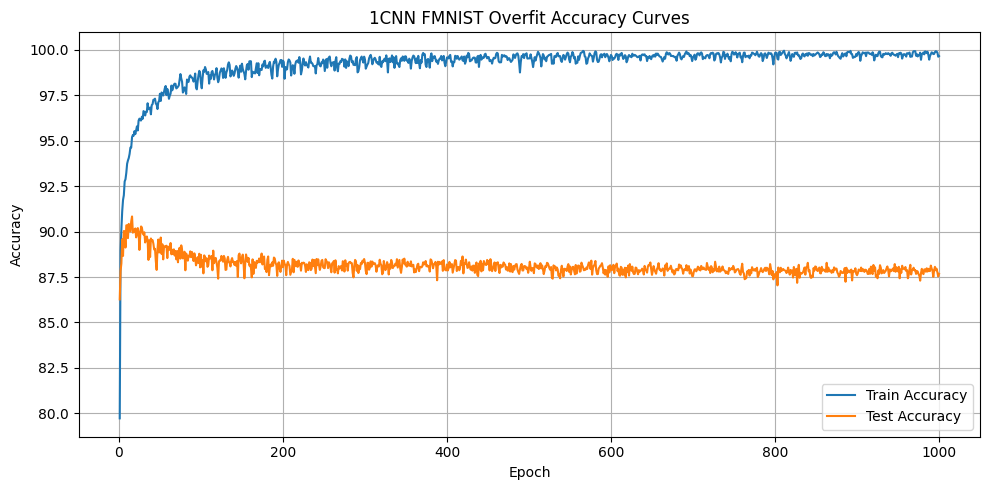

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"1CNN FMNIST Overfit Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"1cnn_fmnist_overfit_accuracy_curve.png")
plt.show()

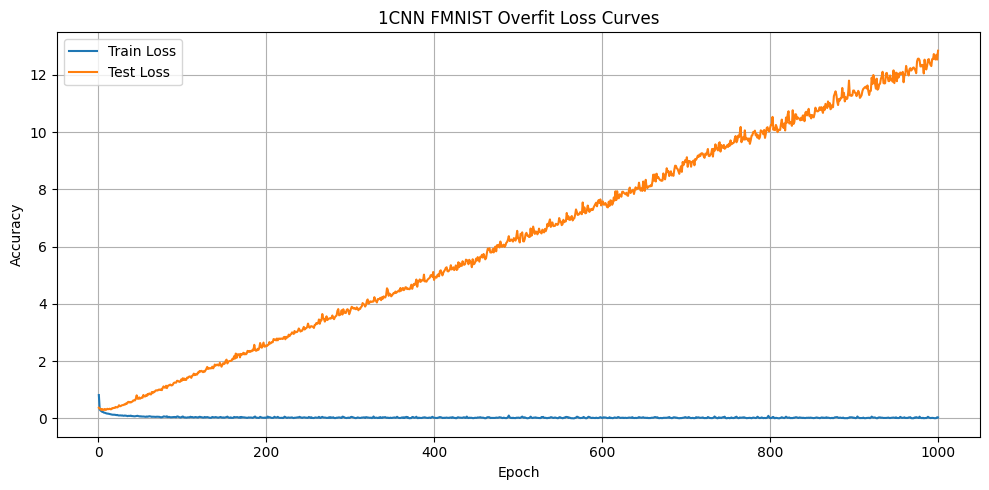

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"1CNN FMNIST Overfit Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"1cnn_fmnist_overfit_loss_curve.png")
plt.show()

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Testing: No augmentation, just normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Apply the specific transform to the specific dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                           download=True, transform=train_transform)

# Note: We use test_transform here to evaluate on clean data
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                          download=True, transform=test_transform)

# 3. Loaders (Same as before)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleCNN().to(device)
# model = FCN_MNIST().to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Optional: Learning rate scheduler

epochs = 1000 # Adjust as needed

train_acc = list()
test_acc = list()
train_loss = list()
test_loss = list()

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    test_running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}, Train: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_acc_ = 100 * correct / total
    scheduler.step() # If using a scheduler

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_acc_ = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {train_running_loss/len(trainloader):.4f}, train acc: {train_acc_:.2f}%, test acc: {test_acc_:.2f}%")
    train_acc.append(train_acc_)
    test_acc.append(test_acc_)
    train_loss.append(train_running_loss/len(trainloader))
    test_loss.append(test_running_loss/len(testloader))
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"ckpt_1cnn_fmnist/epoch_{epoch+1}.pth")

Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 1, Loss: 1.5377, train acc: 49.20%, test acc: 67.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 2, Loss: 1.1774, train acc: 60.86%, test acc: 69.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 3, Loss: 1.0838, train acc: 63.32%, test acc: 70.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 4, Loss: 1.0264, train acc: 65.20%, test acc: 72.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 5, Loss: 0.9905, train acc: 66.25%, test acc: 73.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s]


Epoch 6, Loss: 0.9674, train acc: 66.94%, test acc: 72.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 7, Loss: 0.9508, train acc: 67.14%, test acc: 74.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 8, Loss: 0.9223, train acc: 68.19%, test acc: 73.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 9, Loss: 0.9032, train acc: 68.90%, test acc: 74.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 10, Loss: 0.8884, train acc: 69.35%, test acc: 74.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 11, Loss: 0.8742, train acc: 69.87%, test acc: 74.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.13it/s]


Epoch 12, Loss: 0.8635, train acc: 70.14%, test acc: 75.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 13, Loss: 0.8476, train acc: 70.84%, test acc: 75.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 14, Loss: 0.8395, train acc: 71.08%, test acc: 75.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 15, Loss: 0.8305, train acc: 71.49%, test acc: 75.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.32it/s]


Epoch 16, Loss: 0.8208, train acc: 71.64%, test acc: 75.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 17, Loss: 0.8127, train acc: 72.05%, test acc: 76.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 18, Loss: 0.8027, train acc: 72.35%, test acc: 76.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 19, Loss: 0.7965, train acc: 72.39%, test acc: 76.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 20, Loss: 0.7893, train acc: 72.58%, test acc: 76.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s]


Epoch 21, Loss: 0.7837, train acc: 72.80%, test acc: 76.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 22, Loss: 0.7743, train acc: 73.17%, test acc: 77.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 23, Loss: 0.7744, train acc: 73.37%, test acc: 76.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 24, Loss: 0.7682, train acc: 73.32%, test acc: 77.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 25, Loss: 0.7631, train acc: 73.57%, test acc: 76.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 26, Loss: 0.7596, train acc: 73.62%, test acc: 77.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 27, Loss: 0.7507, train acc: 74.24%, test acc: 77.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 28, Loss: 0.7460, train acc: 74.00%, test acc: 76.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 29, Loss: 0.7405, train acc: 74.33%, test acc: 78.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 30, Loss: 0.7381, train acc: 74.56%, test acc: 77.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 31, Loss: 0.7296, train acc: 74.73%, test acc: 77.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.20it/s]


Epoch 32, Loss: 0.7293, train acc: 74.71%, test acc: 77.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 33, Loss: 0.7303, train acc: 74.75%, test acc: 78.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 34, Loss: 0.7203, train acc: 75.06%, test acc: 78.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.17it/s]


Epoch 35, Loss: 0.7166, train acc: 75.25%, test acc: 77.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 36, Loss: 0.7162, train acc: 75.12%, test acc: 78.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.21it/s]


Epoch 37, Loss: 0.7119, train acc: 75.26%, test acc: 78.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 38, Loss: 0.7066, train acc: 75.45%, test acc: 78.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 39, Loss: 0.7047, train acc: 75.38%, test acc: 78.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 40, Loss: 0.7027, train acc: 75.49%, test acc: 78.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 41, Loss: 0.6968, train acc: 75.72%, test acc: 78.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 42, Loss: 0.6961, train acc: 75.67%, test acc: 79.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 43, Loss: 0.6923, train acc: 76.03%, test acc: 78.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 44, Loss: 0.6939, train acc: 75.92%, test acc: 78.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 45, Loss: 0.6901, train acc: 76.00%, test acc: 79.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 46, Loss: 0.6906, train acc: 76.10%, test acc: 79.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 47, Loss: 0.6883, train acc: 76.03%, test acc: 79.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 48, Loss: 0.6785, train acc: 76.49%, test acc: 79.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 49, Loss: 0.6813, train acc: 76.28%, test acc: 79.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 50, Loss: 0.6765, train acc: 76.60%, test acc: 79.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 51, Loss: 0.6749, train acc: 76.66%, test acc: 79.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 52, Loss: 0.6709, train acc: 76.66%, test acc: 79.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 53, Loss: 0.6716, train acc: 76.82%, test acc: 79.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 54, Loss: 0.6657, train acc: 76.92%, test acc: 79.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 55, Loss: 0.6652, train acc: 76.80%, test acc: 79.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 56, Loss: 0.6631, train acc: 77.09%, test acc: 79.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 57, Loss: 0.6617, train acc: 76.97%, test acc: 79.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 58, Loss: 0.6639, train acc: 77.08%, test acc: 79.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 59, Loss: 0.6581, train acc: 77.10%, test acc: 79.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 60, Loss: 0.6557, train acc: 77.20%, test acc: 79.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 61, Loss: 0.6583, train acc: 77.26%, test acc: 79.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 62, Loss: 0.6543, train acc: 77.19%, test acc: 79.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 63, Loss: 0.6530, train acc: 77.54%, test acc: 79.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 64, Loss: 0.6530, train acc: 77.31%, test acc: 80.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 65, Loss: 0.6513, train acc: 77.47%, test acc: 79.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 66, Loss: 0.6469, train acc: 77.44%, test acc: 80.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 67, Loss: 0.6497, train acc: 77.48%, test acc: 79.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 68, Loss: 0.6494, train acc: 77.47%, test acc: 80.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 69, Loss: 0.6420, train acc: 77.73%, test acc: 80.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 70, Loss: 0.6453, train acc: 77.66%, test acc: 80.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 71, Loss: 0.6441, train acc: 77.59%, test acc: 80.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 72, Loss: 0.6398, train acc: 77.86%, test acc: 79.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 73, Loss: 0.6334, train acc: 77.90%, test acc: 80.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 74, Loss: 0.6384, train acc: 77.87%, test acc: 80.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 75, Loss: 0.6350, train acc: 77.93%, test acc: 80.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 76, Loss: 0.6330, train acc: 77.90%, test acc: 80.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.32it/s]


Epoch 77, Loss: 0.6375, train acc: 77.95%, test acc: 80.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 78, Loss: 0.6344, train acc: 78.09%, test acc: 80.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 79, Loss: 0.6319, train acc: 78.15%, test acc: 80.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 80, Loss: 0.6338, train acc: 78.16%, test acc: 80.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 81, Loss: 0.6317, train acc: 78.03%, test acc: 80.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 82, Loss: 0.6277, train acc: 78.34%, test acc: 80.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 83, Loss: 0.6282, train acc: 78.17%, test acc: 80.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 84, Loss: 0.6274, train acc: 78.35%, test acc: 80.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 85, Loss: 0.6270, train acc: 78.30%, test acc: 80.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 86, Loss: 0.6260, train acc: 78.26%, test acc: 80.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 87, Loss: 0.6226, train acc: 78.48%, test acc: 81.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 88, Loss: 0.6232, train acc: 78.39%, test acc: 80.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 89, Loss: 0.6209, train acc: 78.37%, test acc: 80.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 90, Loss: 0.6191, train acc: 78.56%, test acc: 80.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 91, Loss: 0.6187, train acc: 78.55%, test acc: 81.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 92, Loss: 0.6206, train acc: 78.55%, test acc: 80.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 93, Loss: 0.6148, train acc: 78.70%, test acc: 80.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 94, Loss: 0.6171, train acc: 78.66%, test acc: 80.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 95, Loss: 0.6164, train acc: 78.91%, test acc: 80.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 96, Loss: 0.6165, train acc: 78.84%, test acc: 80.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 97, Loss: 0.6136, train acc: 78.81%, test acc: 80.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 98, Loss: 0.6150, train acc: 78.75%, test acc: 81.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 99, Loss: 0.6147, train acc: 78.90%, test acc: 80.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 100, Loss: 0.6095, train acc: 78.83%, test acc: 80.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 101, Loss: 0.6145, train acc: 78.72%, test acc: 81.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 102, Loss: 0.6136, train acc: 78.63%, test acc: 80.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 103, Loss: 0.6100, train acc: 78.91%, test acc: 81.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 104, Loss: 0.6080, train acc: 78.94%, test acc: 80.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 105, Loss: 0.6105, train acc: 78.94%, test acc: 81.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 106, Loss: 0.6119, train acc: 78.82%, test acc: 81.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 107, Loss: 0.6086, train acc: 78.92%, test acc: 81.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 108, Loss: 0.6118, train acc: 78.95%, test acc: 81.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 109, Loss: 0.6081, train acc: 78.92%, test acc: 81.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 110, Loss: 0.6045, train acc: 79.18%, test acc: 80.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 111, Loss: 0.6080, train acc: 79.01%, test acc: 81.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 112, Loss: 0.6036, train acc: 79.13%, test acc: 81.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 113, Loss: 0.6060, train acc: 79.08%, test acc: 80.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 114, Loss: 0.6042, train acc: 79.11%, test acc: 81.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 115, Loss: 0.6060, train acc: 79.02%, test acc: 81.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 116, Loss: 0.6035, train acc: 79.27%, test acc: 81.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 117, Loss: 0.6008, train acc: 79.03%, test acc: 81.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 118, Loss: 0.6005, train acc: 79.33%, test acc: 81.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 119, Loss: 0.6028, train acc: 79.16%, test acc: 81.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 120, Loss: 0.6031, train acc: 79.11%, test acc: 81.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 121, Loss: 0.6012, train acc: 79.02%, test acc: 81.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 122, Loss: 0.6012, train acc: 79.21%, test acc: 81.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 123, Loss: 0.6022, train acc: 79.14%, test acc: 81.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 124, Loss: 0.5988, train acc: 79.22%, test acc: 81.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 125, Loss: 0.5981, train acc: 79.16%, test acc: 81.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 126, Loss: 0.5998, train acc: 79.43%, test acc: 81.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 127, Loss: 0.5966, train acc: 79.36%, test acc: 81.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 128, Loss: 0.6002, train acc: 79.18%, test acc: 81.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 129, Loss: 0.5978, train acc: 79.22%, test acc: 81.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 130, Loss: 0.5965, train acc: 79.42%, test acc: 81.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 131, Loss: 0.5978, train acc: 79.40%, test acc: 81.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 132, Loss: 0.5967, train acc: 79.52%, test acc: 81.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 133, Loss: 0.5983, train acc: 79.43%, test acc: 81.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 134, Loss: 0.5990, train acc: 79.43%, test acc: 81.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 135, Loss: 0.5968, train acc: 79.37%, test acc: 81.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 136, Loss: 0.5970, train acc: 79.28%, test acc: 81.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 137, Loss: 0.5946, train acc: 79.44%, test acc: 81.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.32it/s]


Epoch 138, Loss: 0.5964, train acc: 79.34%, test acc: 81.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 139, Loss: 0.5968, train acc: 79.33%, test acc: 81.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 140, Loss: 0.5974, train acc: 79.45%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 141, Loss: 0.5937, train acc: 79.50%, test acc: 81.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 142, Loss: 0.5946, train acc: 79.44%, test acc: 81.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.19it/s]


Epoch 143, Loss: 0.5940, train acc: 79.57%, test acc: 81.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 144, Loss: 0.5959, train acc: 79.33%, test acc: 81.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 145, Loss: 0.5931, train acc: 79.66%, test acc: 81.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 146, Loss: 0.5952, train acc: 79.46%, test acc: 81.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 147, Loss: 0.5938, train acc: 79.64%, test acc: 81.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 148, Loss: 0.5905, train acc: 79.52%, test acc: 81.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 149, Loss: 0.5932, train acc: 79.59%, test acc: 81.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 150, Loss: 0.5907, train acc: 79.60%, test acc: 81.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 151, Loss: 0.5915, train acc: 79.51%, test acc: 81.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 152, Loss: 0.5913, train acc: 79.52%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 153, Loss: 0.5886, train acc: 79.57%, test acc: 81.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 154, Loss: 0.5911, train acc: 79.39%, test acc: 81.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 155, Loss: 0.5904, train acc: 79.65%, test acc: 81.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 156, Loss: 0.5888, train acc: 79.58%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 157, Loss: 0.5910, train acc: 79.72%, test acc: 81.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 158, Loss: 0.5926, train acc: 79.75%, test acc: 81.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 159, Loss: 0.5913, train acc: 79.61%, test acc: 81.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 160, Loss: 0.5910, train acc: 79.68%, test acc: 81.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 161, Loss: 0.5903, train acc: 79.55%, test acc: 81.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 162, Loss: 0.5920, train acc: 79.48%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 163, Loss: 0.5885, train acc: 79.71%, test acc: 81.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 164, Loss: 0.5938, train acc: 79.55%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 165, Loss: 0.5902, train acc: 79.36%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 166, Loss: 0.5903, train acc: 79.74%, test acc: 81.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 167, Loss: 0.5896, train acc: 79.58%, test acc: 81.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 168, Loss: 0.5886, train acc: 79.54%, test acc: 81.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 169, Loss: 0.5910, train acc: 79.70%, test acc: 81.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 170, Loss: 0.5877, train acc: 79.59%, test acc: 81.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 171, Loss: 0.5888, train acc: 79.83%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 172, Loss: 0.5892, train acc: 79.68%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 173, Loss: 0.5883, train acc: 79.64%, test acc: 81.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 174, Loss: 0.5876, train acc: 79.71%, test acc: 81.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 175, Loss: 0.5875, train acc: 79.60%, test acc: 81.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 176, Loss: 0.5923, train acc: 79.64%, test acc: 81.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 177, Loss: 0.5866, train acc: 79.73%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 178, Loss: 0.5906, train acc: 79.55%, test acc: 81.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 179, Loss: 0.5895, train acc: 79.69%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 180, Loss: 0.5880, train acc: 79.72%, test acc: 81.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 181, Loss: 0.5880, train acc: 79.73%, test acc: 81.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 182, Loss: 0.5900, train acc: 79.62%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 183, Loss: 0.5888, train acc: 79.64%, test acc: 81.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 184, Loss: 0.5908, train acc: 79.68%, test acc: 81.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 185, Loss: 0.5877, train acc: 79.71%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 186, Loss: 0.5884, train acc: 79.73%, test acc: 81.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 187, Loss: 0.5862, train acc: 79.58%, test acc: 81.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 188, Loss: 0.5894, train acc: 79.62%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 189, Loss: 0.5922, train acc: 79.64%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 190, Loss: 0.5852, train acc: 79.76%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 191, Loss: 0.5878, train acc: 79.75%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.17it/s]


Epoch 192, Loss: 0.5899, train acc: 79.64%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 193, Loss: 0.5879, train acc: 79.66%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 194, Loss: 0.5892, train acc: 79.77%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 195, Loss: 0.5917, train acc: 79.72%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.19it/s]


Epoch 196, Loss: 0.5934, train acc: 79.62%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 197, Loss: 0.5868, train acc: 79.80%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 198, Loss: 0.5933, train acc: 79.63%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 199, Loss: 0.5882, train acc: 79.61%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 200, Loss: 0.5907, train acc: 79.52%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 201, Loss: 0.5848, train acc: 79.75%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 202, Loss: 0.5858, train acc: 79.69%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 203, Loss: 0.5890, train acc: 79.57%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 204, Loss: 0.5873, train acc: 79.70%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


Epoch 205, Loss: 0.5859, train acc: 79.82%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 206, Loss: 0.5884, train acc: 79.87%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.11it/s]


Epoch 207, Loss: 0.5870, train acc: 79.75%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 208, Loss: 0.5921, train acc: 79.60%, test acc: 81.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 209, Loss: 0.5866, train acc: 79.54%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 210, Loss: 0.5903, train acc: 79.68%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 211, Loss: 0.5887, train acc: 79.70%, test acc: 81.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 212, Loss: 0.5904, train acc: 79.67%, test acc: 81.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.02it/s]


Epoch 213, Loss: 0.5890, train acc: 79.59%, test acc: 81.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 214, Loss: 0.5874, train acc: 79.69%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.93it/s]


Epoch 215, Loss: 0.5910, train acc: 79.54%, test acc: 81.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 216, Loss: 0.5848, train acc: 79.65%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 217, Loss: 0.5876, train acc: 79.76%, test acc: 81.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 218, Loss: 0.5927, train acc: 79.57%, test acc: 81.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 219, Loss: 0.5887, train acc: 79.73%, test acc: 81.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 220, Loss: 0.5909, train acc: 79.66%, test acc: 81.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 221, Loss: 0.5906, train acc: 79.59%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.01it/s]


Epoch 222, Loss: 0.5889, train acc: 79.76%, test acc: 81.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.00it/s]


Epoch 223, Loss: 0.5892, train acc: 79.79%, test acc: 81.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 224, Loss: 0.5893, train acc: 79.58%, test acc: 81.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.04it/s]


Epoch 225, Loss: 0.5880, train acc: 79.62%, test acc: 81.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 226, Loss: 0.5882, train acc: 79.66%, test acc: 81.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.91it/s]


Epoch 227, Loss: 0.5880, train acc: 79.74%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 228, Loss: 0.5859, train acc: 79.80%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 229, Loss: 0.5905, train acc: 79.63%, test acc: 81.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 47.03it/s]


Epoch 230, Loss: 0.5860, train acc: 79.69%, test acc: 81.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 231, Loss: 0.5891, train acc: 79.71%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.99it/s]


Epoch 232, Loss: 0.5877, train acc: 79.95%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 233, Loss: 0.5886, train acc: 79.70%, test acc: 81.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 234, Loss: 0.5914, train acc: 79.66%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 235, Loss: 0.5876, train acc: 79.78%, test acc: 81.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 236, Loss: 0.5877, train acc: 79.68%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 237, Loss: 0.5902, train acc: 79.75%, test acc: 81.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 238, Loss: 0.5921, train acc: 79.55%, test acc: 81.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 239, Loss: 0.5856, train acc: 79.69%, test acc: 81.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 240, Loss: 0.5867, train acc: 79.77%, test acc: 81.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 241, Loss: 0.5867, train acc: 79.83%, test acc: 81.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 242, Loss: 0.5879, train acc: 79.68%, test acc: 81.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 243, Loss: 0.5911, train acc: 79.51%, test acc: 81.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 244, Loss: 0.5892, train acc: 79.73%, test acc: 81.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 245, Loss: 0.5890, train acc: 79.79%, test acc: 81.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 246, Loss: 0.5876, train acc: 79.66%, test acc: 81.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 247, Loss: 0.5900, train acc: 79.69%, test acc: 81.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.32it/s]


Epoch 248, Loss: 0.5843, train acc: 79.75%, test acc: 81.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 249, Loss: 0.5884, train acc: 79.72%, test acc: 81.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 250, Loss: 0.5840, train acc: 79.87%, test acc: 81.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.20it/s]


Epoch 251, Loss: 0.5837, train acc: 79.92%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 252, Loss: 0.5870, train acc: 79.82%, test acc: 81.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 253, Loss: 0.5896, train acc: 79.62%, test acc: 81.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 254, Loss: 0.5848, train acc: 79.84%, test acc: 81.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 255, Loss: 0.5884, train acc: 79.61%, test acc: 81.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 256, Loss: 0.5870, train acc: 79.94%, test acc: 81.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 257, Loss: 0.5887, train acc: 79.71%, test acc: 81.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 258, Loss: 0.5850, train acc: 79.75%, test acc: 81.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 259, Loss: 0.5852, train acc: 79.90%, test acc: 81.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 260, Loss: 0.5868, train acc: 79.67%, test acc: 81.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 261, Loss: 0.5841, train acc: 79.83%, test acc: 81.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 262, Loss: 0.5817, train acc: 79.85%, test acc: 81.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 263, Loss: 0.5857, train acc: 79.83%, test acc: 82.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.16it/s]


Epoch 264, Loss: 0.5836, train acc: 80.06%, test acc: 81.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 265, Loss: 0.5811, train acc: 79.75%, test acc: 81.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 266, Loss: 0.5842, train acc: 79.73%, test acc: 82.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 267, Loss: 0.5839, train acc: 79.90%, test acc: 81.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.16it/s]


Epoch 268, Loss: 0.5860, train acc: 79.83%, test acc: 81.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 269, Loss: 0.5851, train acc: 79.70%, test acc: 81.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 270, Loss: 0.5804, train acc: 79.87%, test acc: 81.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.13it/s]


Epoch 271, Loss: 0.5832, train acc: 79.92%, test acc: 81.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 272, Loss: 0.5836, train acc: 79.91%, test acc: 82.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 273, Loss: 0.5821, train acc: 80.06%, test acc: 81.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 274, Loss: 0.5825, train acc: 79.84%, test acc: 82.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 275, Loss: 0.5826, train acc: 79.92%, test acc: 81.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 276, Loss: 0.5852, train acc: 79.88%, test acc: 81.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 277, Loss: 0.5824, train acc: 79.81%, test acc: 81.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 278, Loss: 0.5849, train acc: 79.87%, test acc: 82.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 279, Loss: 0.5813, train acc: 79.99%, test acc: 81.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 280, Loss: 0.5788, train acc: 79.93%, test acc: 81.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 281, Loss: 0.5778, train acc: 80.25%, test acc: 81.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 282, Loss: 0.5798, train acc: 79.94%, test acc: 82.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 283, Loss: 0.5825, train acc: 79.89%, test acc: 82.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 284, Loss: 0.5803, train acc: 79.82%, test acc: 81.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.05it/s]


Epoch 285, Loss: 0.5820, train acc: 79.83%, test acc: 81.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 286, Loss: 0.5746, train acc: 80.13%, test acc: 81.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 287, Loss: 0.5773, train acc: 80.04%, test acc: 81.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.07it/s]


Epoch 288, Loss: 0.5820, train acc: 80.09%, test acc: 82.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 289, Loss: 0.5797, train acc: 79.99%, test acc: 81.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 290, Loss: 0.5799, train acc: 79.89%, test acc: 82.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 291, Loss: 0.5764, train acc: 80.10%, test acc: 82.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.02it/s]


Epoch 292, Loss: 0.5764, train acc: 80.05%, test acc: 82.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 293, Loss: 0.5795, train acc: 79.95%, test acc: 82.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.10it/s]


Epoch 294, Loss: 0.5793, train acc: 80.01%, test acc: 82.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 295, Loss: 0.5776, train acc: 80.11%, test acc: 81.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 296, Loss: 0.5749, train acc: 79.92%, test acc: 82.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.11it/s]


Epoch 297, Loss: 0.5729, train acc: 80.24%, test acc: 82.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 298, Loss: 0.5719, train acc: 80.27%, test acc: 81.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 299, Loss: 0.5725, train acc: 80.28%, test acc: 81.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.21it/s]


Epoch 300, Loss: 0.5749, train acc: 80.09%, test acc: 81.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 301, Loss: 0.5738, train acc: 80.09%, test acc: 82.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 302, Loss: 0.5740, train acc: 80.22%, test acc: 82.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 303, Loss: 0.5728, train acc: 80.12%, test acc: 82.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 304, Loss: 0.5718, train acc: 80.11%, test acc: 82.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 305, Loss: 0.5719, train acc: 80.39%, test acc: 82.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 306, Loss: 0.5735, train acc: 79.97%, test acc: 81.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 307, Loss: 0.5722, train acc: 80.14%, test acc: 82.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 308, Loss: 0.5697, train acc: 80.34%, test acc: 82.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 309, Loss: 0.5720, train acc: 80.31%, test acc: 82.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 310, Loss: 0.5652, train acc: 80.48%, test acc: 82.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 311, Loss: 0.5714, train acc: 80.24%, test acc: 82.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 312, Loss: 0.5674, train acc: 80.44%, test acc: 82.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 313, Loss: 0.5701, train acc: 80.21%, test acc: 82.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 314, Loss: 0.5664, train acc: 80.32%, test acc: 82.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 315, Loss: 0.5668, train acc: 80.36%, test acc: 82.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 316, Loss: 0.5716, train acc: 80.26%, test acc: 82.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 317, Loss: 0.5671, train acc: 80.33%, test acc: 82.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 318, Loss: 0.5648, train acc: 80.48%, test acc: 82.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s]


Epoch 319, Loss: 0.5630, train acc: 80.52%, test acc: 82.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 320, Loss: 0.5657, train acc: 80.37%, test acc: 82.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 321, Loss: 0.5651, train acc: 80.52%, test acc: 82.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 322, Loss: 0.5628, train acc: 80.52%, test acc: 82.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 323, Loss: 0.5642, train acc: 80.39%, test acc: 81.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 324, Loss: 0.5660, train acc: 80.45%, test acc: 82.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 325, Loss: 0.5642, train acc: 80.61%, test acc: 82.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 326, Loss: 0.5623, train acc: 80.60%, test acc: 82.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 327, Loss: 0.5605, train acc: 80.51%, test acc: 82.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 328, Loss: 0.5629, train acc: 80.61%, test acc: 82.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 329, Loss: 0.5612, train acc: 80.64%, test acc: 82.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 330, Loss: 0.5588, train acc: 80.59%, test acc: 82.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 331, Loss: 0.5613, train acc: 80.50%, test acc: 82.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 332, Loss: 0.5617, train acc: 80.63%, test acc: 82.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.13it/s]


Epoch 333, Loss: 0.5569, train acc: 80.79%, test acc: 82.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 334, Loss: 0.5597, train acc: 80.66%, test acc: 81.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 335, Loss: 0.5592, train acc: 80.65%, test acc: 82.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 45.91it/s]


Epoch 336, Loss: 0.5569, train acc: 80.72%, test acc: 82.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 337, Loss: 0.5567, train acc: 80.82%, test acc: 82.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 45.98it/s]


Epoch 338, Loss: 0.5553, train acc: 80.69%, test acc: 82.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 339, Loss: 0.5574, train acc: 80.76%, test acc: 82.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 340, Loss: 0.5538, train acc: 80.57%, test acc: 82.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.10it/s]


Epoch 341, Loss: 0.5542, train acc: 80.81%, test acc: 82.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 342, Loss: 0.5520, train acc: 80.95%, test acc: 82.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 343, Loss: 0.5540, train acc: 80.81%, test acc: 82.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 344, Loss: 0.5490, train acc: 80.78%, test acc: 82.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 345, Loss: 0.5522, train acc: 80.89%, test acc: 82.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 346, Loss: 0.5479, train acc: 80.72%, test acc: 82.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 347, Loss: 0.5545, train acc: 80.84%, test acc: 82.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 348, Loss: 0.5536, train acc: 80.92%, test acc: 82.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 349, Loss: 0.5497, train acc: 80.95%, test acc: 82.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 350, Loss: 0.5499, train acc: 80.83%, test acc: 83.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 351, Loss: 0.5496, train acc: 80.89%, test acc: 82.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 352, Loss: 0.5476, train acc: 81.05%, test acc: 83.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 353, Loss: 0.5493, train acc: 80.94%, test acc: 83.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 354, Loss: 0.5490, train acc: 80.85%, test acc: 82.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 355, Loss: 0.5474, train acc: 81.02%, test acc: 82.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 356, Loss: 0.5458, train acc: 81.05%, test acc: 82.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 357, Loss: 0.5481, train acc: 81.05%, test acc: 82.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.13it/s]


Epoch 358, Loss: 0.5448, train acc: 81.17%, test acc: 82.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 359, Loss: 0.5420, train acc: 81.12%, test acc: 82.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 360, Loss: 0.5447, train acc: 80.99%, test acc: 82.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.18it/s]


Epoch 361, Loss: 0.5442, train acc: 81.19%, test acc: 82.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 362, Loss: 0.5421, train acc: 81.31%, test acc: 82.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 363, Loss: 0.5438, train acc: 81.04%, test acc: 82.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 364, Loss: 0.5432, train acc: 81.20%, test acc: 82.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s]


Epoch 365, Loss: 0.5441, train acc: 81.09%, test acc: 82.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 366, Loss: 0.5423, train acc: 81.21%, test acc: 82.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 367, Loss: 0.5405, train acc: 81.27%, test acc: 83.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 368, Loss: 0.5423, train acc: 81.30%, test acc: 82.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.06it/s]


Epoch 369, Loss: 0.5392, train acc: 81.33%, test acc: 82.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 370, Loss: 0.5371, train acc: 81.30%, test acc: 82.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 371, Loss: 0.5397, train acc: 81.35%, test acc: 83.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 372, Loss: 0.5399, train acc: 81.31%, test acc: 83.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 373, Loss: 0.5398, train acc: 81.30%, test acc: 83.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 374, Loss: 0.5360, train acc: 81.40%, test acc: 83.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 375, Loss: 0.5396, train acc: 81.19%, test acc: 82.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 376, Loss: 0.5365, train acc: 81.30%, test acc: 83.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 377, Loss: 0.5335, train acc: 81.43%, test acc: 83.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 378, Loss: 0.5336, train acc: 81.41%, test acc: 83.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 379, Loss: 0.5411, train acc: 81.27%, test acc: 82.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 380, Loss: 0.5359, train acc: 81.31%, test acc: 83.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 381, Loss: 0.5338, train acc: 81.33%, test acc: 83.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 382, Loss: 0.5329, train acc: 81.39%, test acc: 83.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 383, Loss: 0.5297, train acc: 81.58%, test acc: 83.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 384, Loss: 0.5336, train acc: 81.60%, test acc: 83.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 385, Loss: 0.5314, train acc: 81.63%, test acc: 83.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 386, Loss: 0.5339, train acc: 81.45%, test acc: 83.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 387, Loss: 0.5343, train acc: 81.39%, test acc: 83.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 388, Loss: 0.5319, train acc: 81.52%, test acc: 83.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 389, Loss: 0.5318, train acc: 81.46%, test acc: 83.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 390, Loss: 0.5306, train acc: 81.57%, test acc: 83.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 391, Loss: 0.5288, train acc: 81.78%, test acc: 83.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 392, Loss: 0.5294, train acc: 81.83%, test acc: 83.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.18it/s]


Epoch 393, Loss: 0.5259, train acc: 81.69%, test acc: 83.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 394, Loss: 0.5264, train acc: 81.68%, test acc: 83.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 395, Loss: 0.5262, train acc: 81.76%, test acc: 83.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 396, Loss: 0.5256, train acc: 81.85%, test acc: 83.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 397, Loss: 0.5254, train acc: 81.61%, test acc: 83.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 398, Loss: 0.5250, train acc: 81.76%, test acc: 83.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 399, Loss: 0.5264, train acc: 81.64%, test acc: 82.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 400, Loss: 0.5242, train acc: 81.75%, test acc: 83.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 401, Loss: 0.5255, train acc: 81.67%, test acc: 83.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 402, Loss: 0.5250, train acc: 81.74%, test acc: 83.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 403, Loss: 0.5239, train acc: 81.75%, test acc: 83.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 404, Loss: 0.5209, train acc: 81.80%, test acc: 83.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 405, Loss: 0.5251, train acc: 81.80%, test acc: 82.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 406, Loss: 0.5233, train acc: 81.82%, test acc: 83.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 407, Loss: 0.5196, train acc: 82.14%, test acc: 83.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 408, Loss: 0.5226, train acc: 81.60%, test acc: 83.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 409, Loss: 0.5211, train acc: 81.92%, test acc: 83.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 410, Loss: 0.5215, train acc: 81.74%, test acc: 83.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 411, Loss: 0.5206, train acc: 81.79%, test acc: 83.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 412, Loss: 0.5221, train acc: 81.87%, test acc: 83.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 413, Loss: 0.5197, train acc: 81.98%, test acc: 83.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.12it/s]


Epoch 414, Loss: 0.5214, train acc: 81.86%, test acc: 83.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 415, Loss: 0.5195, train acc: 82.03%, test acc: 83.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 416, Loss: 0.5179, train acc: 81.88%, test acc: 83.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 417, Loss: 0.5182, train acc: 81.93%, test acc: 83.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 418, Loss: 0.5169, train acc: 82.09%, test acc: 83.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 419, Loss: 0.5152, train acc: 82.03%, test acc: 83.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 420, Loss: 0.5141, train acc: 82.11%, test acc: 83.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 421, Loss: 0.5194, train acc: 81.94%, test acc: 83.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 422, Loss: 0.5136, train acc: 82.06%, test acc: 83.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 423, Loss: 0.5151, train acc: 82.05%, test acc: 83.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 424, Loss: 0.5118, train acc: 82.23%, test acc: 83.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.21it/s]


Epoch 425, Loss: 0.5176, train acc: 81.95%, test acc: 83.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 426, Loss: 0.5149, train acc: 82.08%, test acc: 83.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 427, Loss: 0.5124, train acc: 82.15%, test acc: 83.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 428, Loss: 0.5127, train acc: 82.03%, test acc: 83.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 429, Loss: 0.5131, train acc: 82.19%, test acc: 83.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 430, Loss: 0.5129, train acc: 82.25%, test acc: 84.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 431, Loss: 0.5119, train acc: 82.21%, test acc: 83.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.21it/s]


Epoch 432, Loss: 0.5130, train acc: 82.00%, test acc: 83.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 433, Loss: 0.5129, train acc: 82.21%, test acc: 83.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.00it/s]


Epoch 434, Loss: 0.5120, train acc: 82.36%, test acc: 83.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 435, Loss: 0.5129, train acc: 82.03%, test acc: 83.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 436, Loss: 0.5089, train acc: 82.24%, test acc: 84.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 437, Loss: 0.5098, train acc: 82.25%, test acc: 83.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 438, Loss: 0.5080, train acc: 82.28%, test acc: 84.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 439, Loss: 0.5077, train acc: 82.34%, test acc: 83.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 440, Loss: 0.5101, train acc: 82.16%, test acc: 83.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 441, Loss: 0.5115, train acc: 82.19%, test acc: 83.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 442, Loss: 0.5067, train acc: 82.29%, test acc: 83.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 443, Loss: 0.5073, train acc: 82.31%, test acc: 83.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 444, Loss: 0.5078, train acc: 82.36%, test acc: 83.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 445, Loss: 0.5071, train acc: 82.26%, test acc: 84.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 446, Loss: 0.5092, train acc: 82.14%, test acc: 84.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 447, Loss: 0.5104, train acc: 82.24%, test acc: 83.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 448, Loss: 0.5110, train acc: 82.23%, test acc: 83.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 449, Loss: 0.5067, train acc: 82.38%, test acc: 83.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.07it/s]


Epoch 450, Loss: 0.5091, train acc: 82.17%, test acc: 83.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.13it/s]


Epoch 451, Loss: 0.5066, train acc: 82.28%, test acc: 84.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 452, Loss: 0.5034, train acc: 82.44%, test acc: 83.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 453, Loss: 0.5034, train acc: 82.45%, test acc: 83.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 454, Loss: 0.5052, train acc: 82.47%, test acc: 84.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 455, Loss: 0.5039, train acc: 82.48%, test acc: 84.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 456, Loss: 0.5042, train acc: 82.40%, test acc: 83.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 457, Loss: 0.5023, train acc: 82.53%, test acc: 83.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 458, Loss: 0.5039, train acc: 82.35%, test acc: 83.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 459, Loss: 0.5040, train acc: 82.57%, test acc: 83.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 460, Loss: 0.5040, train acc: 82.46%, test acc: 84.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 461, Loss: 0.5030, train acc: 82.63%, test acc: 84.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 462, Loss: 0.5009, train acc: 82.53%, test acc: 84.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.15it/s]


Epoch 463, Loss: 0.5017, train acc: 82.57%, test acc: 83.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 464, Loss: 0.5030, train acc: 82.47%, test acc: 84.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 465, Loss: 0.5015, train acc: 82.43%, test acc: 84.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 466, Loss: 0.5044, train acc: 82.51%, test acc: 83.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 467, Loss: 0.5028, train acc: 82.46%, test acc: 84.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 468, Loss: 0.5014, train acc: 82.53%, test acc: 84.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.09it/s]


Epoch 469, Loss: 0.5035, train acc: 82.58%, test acc: 84.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 470, Loss: 0.5003, train acc: 82.59%, test acc: 83.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 471, Loss: 0.4992, train acc: 82.52%, test acc: 84.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 472, Loss: 0.4985, train acc: 82.65%, test acc: 84.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 473, Loss: 0.4984, train acc: 82.62%, test acc: 84.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 474, Loss: 0.4994, train acc: 82.75%, test acc: 83.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 475, Loss: 0.5017, train acc: 82.59%, test acc: 84.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 476, Loss: 0.5008, train acc: 82.48%, test acc: 83.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 477, Loss: 0.5013, train acc: 82.67%, test acc: 83.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 478, Loss: 0.5013, train acc: 82.49%, test acc: 84.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.14it/s]


Epoch 479, Loss: 0.5008, train acc: 82.63%, test acc: 84.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 480, Loss: 0.5010, train acc: 82.74%, test acc: 84.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 481, Loss: 0.4972, train acc: 82.67%, test acc: 83.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.19it/s]


Epoch 482, Loss: 0.4991, train acc: 82.70%, test acc: 84.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 483, Loss: 0.5019, train acc: 82.56%, test acc: 84.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 484, Loss: 0.4952, train acc: 82.58%, test acc: 83.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 485, Loss: 0.4967, train acc: 82.68%, test acc: 84.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 486, Loss: 0.4990, train acc: 82.72%, test acc: 83.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.19it/s]


Epoch 487, Loss: 0.4981, train acc: 82.56%, test acc: 84.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 488, Loss: 0.4965, train acc: 82.72%, test acc: 84.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 489, Loss: 0.4977, train acc: 82.54%, test acc: 84.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 490, Loss: 0.4954, train acc: 82.69%, test acc: 84.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.06it/s]


Epoch 491, Loss: 0.4937, train acc: 82.66%, test acc: 84.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 492, Loss: 0.4940, train acc: 82.80%, test acc: 84.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 493, Loss: 0.4934, train acc: 82.95%, test acc: 84.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 494, Loss: 0.4946, train acc: 82.87%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 495, Loss: 0.4949, train acc: 82.71%, test acc: 84.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 496, Loss: 0.4965, train acc: 82.61%, test acc: 84.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 497, Loss: 0.4970, train acc: 82.64%, test acc: 84.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 498, Loss: 0.4959, train acc: 82.88%, test acc: 84.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 499, Loss: 0.4948, train acc: 82.81%, test acc: 84.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 500, Loss: 0.4955, train acc: 82.91%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 501, Loss: 0.4947, train acc: 82.78%, test acc: 84.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 502, Loss: 0.4934, train acc: 82.72%, test acc: 84.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 503, Loss: 0.4956, train acc: 82.67%, test acc: 84.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 504, Loss: 0.4971, train acc: 82.77%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 505, Loss: 0.4947, train acc: 82.87%, test acc: 84.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 506, Loss: 0.4919, train acc: 82.90%, test acc: 84.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 507, Loss: 0.4952, train acc: 82.65%, test acc: 84.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 508, Loss: 0.4910, train acc: 82.89%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 509, Loss: 0.4917, train acc: 82.97%, test acc: 84.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 510, Loss: 0.4949, train acc: 82.83%, test acc: 84.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 511, Loss: 0.4923, train acc: 82.84%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 512, Loss: 0.4914, train acc: 83.12%, test acc: 84.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 513, Loss: 0.4900, train acc: 82.94%, test acc: 84.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 514, Loss: 0.4906, train acc: 82.93%, test acc: 84.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 515, Loss: 0.4902, train acc: 82.97%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 516, Loss: 0.4905, train acc: 83.06%, test acc: 84.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 517, Loss: 0.4915, train acc: 82.85%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.08it/s]


Epoch 518, Loss: 0.4912, train acc: 82.86%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 519, Loss: 0.4912, train acc: 82.91%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 520, Loss: 0.4912, train acc: 82.83%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 521, Loss: 0.4932, train acc: 82.81%, test acc: 84.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.12it/s]


Epoch 522, Loss: 0.4932, train acc: 82.87%, test acc: 84.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 523, Loss: 0.4866, train acc: 83.06%, test acc: 84.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 524, Loss: 0.4918, train acc: 83.03%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.15it/s]


Epoch 525, Loss: 0.4921, train acc: 82.82%, test acc: 84.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 526, Loss: 0.4914, train acc: 82.97%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 527, Loss: 0.4903, train acc: 82.96%, test acc: 84.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 528, Loss: 0.4892, train acc: 82.89%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 529, Loss: 0.4933, train acc: 82.89%, test acc: 84.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 530, Loss: 0.4896, train acc: 82.92%, test acc: 84.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.15it/s]


Epoch 531, Loss: 0.4894, train acc: 82.91%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 532, Loss: 0.4933, train acc: 82.86%, test acc: 84.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 533, Loss: 0.4910, train acc: 82.92%, test acc: 84.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.18it/s]


Epoch 534, Loss: 0.4891, train acc: 83.12%, test acc: 84.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 535, Loss: 0.4892, train acc: 83.23%, test acc: 84.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 536, Loss: 0.4920, train acc: 83.09%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 537, Loss: 0.4900, train acc: 82.87%, test acc: 84.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 538, Loss: 0.4902, train acc: 82.90%, test acc: 84.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 539, Loss: 0.4887, train acc: 83.14%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 540, Loss: 0.4898, train acc: 82.93%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 541, Loss: 0.4906, train acc: 82.93%, test acc: 84.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 542, Loss: 0.4922, train acc: 82.87%, test acc: 84.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 543, Loss: 0.4885, train acc: 82.97%, test acc: 84.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 544, Loss: 0.4880, train acc: 83.04%, test acc: 84.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 545, Loss: 0.4909, train acc: 82.98%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 546, Loss: 0.4912, train acc: 82.90%, test acc: 84.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 547, Loss: 0.4897, train acc: 82.96%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 548, Loss: 0.4878, train acc: 83.06%, test acc: 84.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 549, Loss: 0.4890, train acc: 82.86%, test acc: 84.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.96it/s]


Epoch 550, Loss: 0.4909, train acc: 82.94%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 551, Loss: 0.4904, train acc: 82.95%, test acc: 84.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 552, Loss: 0.4899, train acc: 82.83%, test acc: 84.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.98it/s]


Epoch 553, Loss: 0.4874, train acc: 83.05%, test acc: 84.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.97it/s]


Epoch 554, Loss: 0.4878, train acc: 83.07%, test acc: 84.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 555, Loss: 0.4907, train acc: 82.97%, test acc: 84.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.90it/s]


Epoch 556, Loss: 0.4877, train acc: 83.05%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 557, Loss: 0.4894, train acc: 83.04%, test acc: 84.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 558, Loss: 0.4903, train acc: 82.92%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 559, Loss: 0.4866, train acc: 83.06%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 560, Loss: 0.4896, train acc: 83.11%, test acc: 84.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 561, Loss: 0.4905, train acc: 83.00%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 562, Loss: 0.4868, train acc: 82.97%, test acc: 84.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 563, Loss: 0.4848, train acc: 83.12%, test acc: 84.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 564, Loss: 0.4868, train acc: 83.06%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 45.90it/s]


Epoch 565, Loss: 0.4862, train acc: 83.04%, test acc: 84.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 566, Loss: 0.4861, train acc: 83.08%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 567, Loss: 0.4877, train acc: 83.20%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 568, Loss: 0.4903, train acc: 83.00%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 569, Loss: 0.4883, train acc: 83.09%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 570, Loss: 0.4890, train acc: 83.05%, test acc: 84.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.16it/s]


Epoch 571, Loss: 0.4894, train acc: 82.91%, test acc: 84.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 572, Loss: 0.4865, train acc: 82.96%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 573, Loss: 0.4879, train acc: 83.09%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.19it/s]


Epoch 574, Loss: 0.4867, train acc: 82.98%, test acc: 84.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 575, Loss: 0.4889, train acc: 83.02%, test acc: 84.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.08it/s]


Epoch 576, Loss: 0.4885, train acc: 83.09%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 577, Loss: 0.4900, train acc: 82.96%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 578, Loss: 0.4892, train acc: 82.93%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 579, Loss: 0.4857, train acc: 83.07%, test acc: 84.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 580, Loss: 0.4856, train acc: 83.15%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 581, Loss: 0.4903, train acc: 83.00%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 582, Loss: 0.4900, train acc: 82.88%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 583, Loss: 0.4880, train acc: 83.11%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 584, Loss: 0.4850, train acc: 83.17%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 585, Loss: 0.4879, train acc: 83.01%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 586, Loss: 0.4852, train acc: 83.09%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 587, Loss: 0.4877, train acc: 82.90%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 588, Loss: 0.4898, train acc: 82.99%, test acc: 84.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 589, Loss: 0.4894, train acc: 83.14%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 590, Loss: 0.4839, train acc: 83.14%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 591, Loss: 0.4875, train acc: 83.03%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 592, Loss: 0.4900, train acc: 82.97%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 593, Loss: 0.4867, train acc: 83.19%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 594, Loss: 0.4899, train acc: 83.02%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 595, Loss: 0.4866, train acc: 83.07%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 596, Loss: 0.4890, train acc: 83.11%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 597, Loss: 0.4898, train acc: 83.00%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 598, Loss: 0.4858, train acc: 83.01%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 45.89it/s]


Epoch 599, Loss: 0.4862, train acc: 83.11%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 600, Loss: 0.4868, train acc: 83.03%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 601, Loss: 0.4881, train acc: 83.14%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 602, Loss: 0.4849, train acc: 83.10%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 603, Loss: 0.4845, train acc: 83.23%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 604, Loss: 0.4874, train acc: 83.04%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 605, Loss: 0.4863, train acc: 83.08%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 606, Loss: 0.4856, train acc: 83.08%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 607, Loss: 0.4893, train acc: 83.15%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 608, Loss: 0.4866, train acc: 83.16%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 609, Loss: 0.4865, train acc: 83.00%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 610, Loss: 0.4861, train acc: 83.02%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 611, Loss: 0.4884, train acc: 83.05%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 612, Loss: 0.4884, train acc: 82.84%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 613, Loss: 0.4847, train acc: 83.11%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 614, Loss: 0.4852, train acc: 83.11%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 615, Loss: 0.4883, train acc: 83.12%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 616, Loss: 0.4896, train acc: 83.00%, test acc: 84.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 617, Loss: 0.4847, train acc: 83.19%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 618, Loss: 0.4905, train acc: 82.92%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 619, Loss: 0.4867, train acc: 83.15%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 620, Loss: 0.4866, train acc: 83.16%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 621, Loss: 0.4879, train acc: 83.07%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 622, Loss: 0.4864, train acc: 83.14%, test acc: 84.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 623, Loss: 0.4900, train acc: 83.06%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 624, Loss: 0.4870, train acc: 83.15%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 625, Loss: 0.4852, train acc: 83.15%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 626, Loss: 0.4882, train acc: 83.06%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 627, Loss: 0.4869, train acc: 83.19%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 628, Loss: 0.4864, train acc: 83.05%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 629, Loss: 0.4863, train acc: 82.92%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s]


Epoch 630, Loss: 0.4886, train acc: 83.03%, test acc: 84.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 631, Loss: 0.4876, train acc: 83.05%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 632, Loss: 0.4886, train acc: 82.97%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.16it/s]


Epoch 633, Loss: 0.4883, train acc: 83.01%, test acc: 84.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 634, Loss: 0.4868, train acc: 83.09%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 635, Loss: 0.4862, train acc: 83.06%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 636, Loss: 0.4881, train acc: 82.89%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 637, Loss: 0.4881, train acc: 83.06%, test acc: 84.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 638, Loss: 0.4874, train acc: 82.98%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 639, Loss: 0.4877, train acc: 83.08%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 640, Loss: 0.4873, train acc: 83.10%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 641, Loss: 0.4877, train acc: 83.03%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 642, Loss: 0.4867, train acc: 83.17%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 643, Loss: 0.4855, train acc: 83.22%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 644, Loss: 0.4882, train acc: 83.02%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 645, Loss: 0.4850, train acc: 83.05%, test acc: 84.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 646, Loss: 0.4871, train acc: 83.15%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 647, Loss: 0.4889, train acc: 83.12%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 648, Loss: 0.4867, train acc: 82.99%, test acc: 84.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.19it/s]


Epoch 649, Loss: 0.4879, train acc: 83.18%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 650, Loss: 0.4894, train acc: 82.95%, test acc: 84.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 651, Loss: 0.4864, train acc: 83.14%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.20it/s]


Epoch 652, Loss: 0.4865, train acc: 83.07%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 653, Loss: 0.4871, train acc: 82.92%, test acc: 84.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 654, Loss: 0.4854, train acc: 83.14%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.17it/s]


Epoch 655, Loss: 0.4855, train acc: 83.05%, test acc: 84.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 656, Loss: 0.4904, train acc: 82.93%, test acc: 84.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 657, Loss: 0.4875, train acc: 83.13%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.17it/s]


Epoch 658, Loss: 0.4878, train acc: 83.05%, test acc: 84.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 659, Loss: 0.4884, train acc: 83.03%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 660, Loss: 0.4836, train acc: 83.10%, test acc: 84.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.21it/s]


Epoch 661, Loss: 0.4881, train acc: 83.09%, test acc: 84.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 662, Loss: 0.4870, train acc: 83.09%, test acc: 84.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 663, Loss: 0.4862, train acc: 83.10%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 664, Loss: 0.4885, train acc: 83.08%, test acc: 84.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 665, Loss: 0.4834, train acc: 83.28%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 666, Loss: 0.4879, train acc: 82.96%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.11it/s]


Epoch 667, Loss: 0.4886, train acc: 82.96%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 668, Loss: 0.4882, train acc: 83.13%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 669, Loss: 0.4877, train acc: 83.08%, test acc: 84.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 670, Loss: 0.4889, train acc: 82.97%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 671, Loss: 0.4888, train acc: 82.97%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.14it/s]


Epoch 672, Loss: 0.4880, train acc: 82.95%, test acc: 84.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 673, Loss: 0.4882, train acc: 83.01%, test acc: 84.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s]


Epoch 674, Loss: 0.4885, train acc: 82.92%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 675, Loss: 0.4910, train acc: 82.94%, test acc: 84.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 676, Loss: 0.4851, train acc: 83.06%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.20it/s]


Epoch 677, Loss: 0.4850, train acc: 83.02%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.20it/s]


Epoch 678, Loss: 0.4873, train acc: 83.00%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 679, Loss: 0.4865, train acc: 83.16%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 680, Loss: 0.4862, train acc: 83.23%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.15it/s]


Epoch 681, Loss: 0.4878, train acc: 83.14%, test acc: 84.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 682, Loss: 0.4853, train acc: 82.97%, test acc: 84.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.15it/s]


Epoch 683, Loss: 0.4873, train acc: 82.98%, test acc: 84.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 684, Loss: 0.4861, train acc: 83.05%, test acc: 84.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.14it/s]


Epoch 685, Loss: 0.4896, train acc: 83.14%, test acc: 84.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 686, Loss: 0.4859, train acc: 83.12%, test acc: 84.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 687, Loss: 0.4868, train acc: 82.98%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 688, Loss: 0.4844, train acc: 83.06%, test acc: 84.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.10it/s]


Epoch 689, Loss: 0.4868, train acc: 83.00%, test acc: 84.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 690, Loss: 0.4854, train acc: 83.08%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 691, Loss: 0.4821, train acc: 83.15%, test acc: 84.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.09it/s]


Epoch 692, Loss: 0.4865, train acc: 83.03%, test acc: 84.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 693, Loss: 0.4856, train acc: 83.00%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 694, Loss: 0.4861, train acc: 83.08%, test acc: 84.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 695, Loss: 0.4856, train acc: 83.18%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.10it/s]


Epoch 696, Loss: 0.4882, train acc: 83.00%, test acc: 84.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 697, Loss: 0.4833, train acc: 83.16%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.09it/s]


Epoch 698, Loss: 0.4875, train acc: 82.96%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 699, Loss: 0.4857, train acc: 83.09%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 700, Loss: 0.4858, train acc: 83.01%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 701, Loss: 0.4855, train acc: 83.18%, test acc: 84.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.04it/s]


Epoch 702, Loss: 0.4840, train acc: 83.17%, test acc: 84.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 703, Loss: 0.4847, train acc: 83.00%, test acc: 84.54%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 704, Loss: 0.4825, train acc: 83.29%, test acc: 84.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 705, Loss: 0.4849, train acc: 83.26%, test acc: 84.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 706, Loss: 0.4829, train acc: 83.24%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 707, Loss: 0.4861, train acc: 82.95%, test acc: 84.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 708, Loss: 0.4867, train acc: 83.14%, test acc: 84.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 709, Loss: 0.4879, train acc: 83.00%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 710, Loss: 0.4883, train acc: 82.92%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 711, Loss: 0.4834, train acc: 83.30%, test acc: 84.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 712, Loss: 0.4836, train acc: 83.13%, test acc: 84.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 713, Loss: 0.4874, train acc: 82.99%, test acc: 84.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 714, Loss: 0.4867, train acc: 82.95%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 715, Loss: 0.4847, train acc: 83.21%, test acc: 84.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 716, Loss: 0.4857, train acc: 83.06%, test acc: 84.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 717, Loss: 0.4866, train acc: 83.06%, test acc: 84.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 718, Loss: 0.4854, train acc: 83.12%, test acc: 84.51%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 719, Loss: 0.4823, train acc: 83.38%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 720, Loss: 0.4834, train acc: 83.10%, test acc: 84.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 721, Loss: 0.4851, train acc: 83.14%, test acc: 84.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 722, Loss: 0.4878, train acc: 83.06%, test acc: 84.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 723, Loss: 0.4831, train acc: 83.31%, test acc: 84.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 724, Loss: 0.4864, train acc: 83.00%, test acc: 84.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.32it/s]


Epoch 725, Loss: 0.4821, train acc: 83.08%, test acc: 84.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 726, Loss: 0.4864, train acc: 82.98%, test acc: 84.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.62it/s]


Epoch 727, Loss: 0.4788, train acc: 83.39%, test acc: 84.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 728, Loss: 0.4849, train acc: 83.15%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 729, Loss: 0.4831, train acc: 83.30%, test acc: 84.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 730, Loss: 0.4842, train acc: 83.10%, test acc: 84.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.32it/s]


Epoch 731, Loss: 0.4868, train acc: 83.07%, test acc: 84.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 732, Loss: 0.4824, train acc: 83.14%, test acc: 84.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 733, Loss: 0.4860, train acc: 83.19%, test acc: 84.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.24it/s]


Epoch 734, Loss: 0.4846, train acc: 83.12%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 735, Loss: 0.4820, train acc: 83.12%, test acc: 84.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 736, Loss: 0.4832, train acc: 83.26%, test acc: 84.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 737, Loss: 0.4836, train acc: 83.21%, test acc: 84.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 738, Loss: 0.4816, train acc: 83.15%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 739, Loss: 0.4824, train acc: 83.16%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 740, Loss: 0.4846, train acc: 82.94%, test acc: 84.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 741, Loss: 0.4857, train acc: 83.10%, test acc: 84.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 742, Loss: 0.4819, train acc: 83.22%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 743, Loss: 0.4842, train acc: 83.30%, test acc: 84.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 744, Loss: 0.4835, train acc: 83.30%, test acc: 84.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 745, Loss: 0.4814, train acc: 83.11%, test acc: 84.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 746, Loss: 0.4818, train acc: 83.21%, test acc: 84.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 747, Loss: 0.4848, train acc: 83.02%, test acc: 84.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 748, Loss: 0.4803, train acc: 83.25%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 749, Loss: 0.4821, train acc: 83.10%, test acc: 84.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 750, Loss: 0.4806, train acc: 83.32%, test acc: 84.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 751, Loss: 0.4802, train acc: 83.20%, test acc: 84.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 752, Loss: 0.4798, train acc: 83.30%, test acc: 84.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 753, Loss: 0.4812, train acc: 83.24%, test acc: 84.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 754, Loss: 0.4812, train acc: 83.12%, test acc: 84.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 755, Loss: 0.4833, train acc: 83.21%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.23it/s]


Epoch 756, Loss: 0.4816, train acc: 83.17%, test acc: 84.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 757, Loss: 0.4788, train acc: 83.48%, test acc: 84.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 758, Loss: 0.4825, train acc: 83.04%, test acc: 84.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 759, Loss: 0.4798, train acc: 83.27%, test acc: 84.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.86it/s]


Epoch 760, Loss: 0.4807, train acc: 83.14%, test acc: 84.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 761, Loss: 0.4796, train acc: 83.26%, test acc: 84.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 762, Loss: 0.4811, train acc: 83.26%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 763, Loss: 0.4778, train acc: 83.42%, test acc: 84.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 764, Loss: 0.4804, train acc: 83.42%, test acc: 84.57%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 765, Loss: 0.4773, train acc: 83.29%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 766, Loss: 0.4829, train acc: 83.06%, test acc: 84.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 767, Loss: 0.4759, train acc: 83.37%, test acc: 84.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 768, Loss: 0.4785, train acc: 83.18%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 769, Loss: 0.4811, train acc: 83.28%, test acc: 84.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 770, Loss: 0.4781, train acc: 83.30%, test acc: 84.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 771, Loss: 0.4818, train acc: 83.13%, test acc: 84.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 772, Loss: 0.4761, train acc: 83.45%, test acc: 84.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 773, Loss: 0.4751, train acc: 83.38%, test acc: 84.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 774, Loss: 0.4770, train acc: 83.27%, test acc: 84.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 775, Loss: 0.4781, train acc: 83.33%, test acc: 84.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 776, Loss: 0.4784, train acc: 83.20%, test acc: 84.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 777, Loss: 0.4751, train acc: 83.35%, test acc: 84.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s]


Epoch 778, Loss: 0.4759, train acc: 83.33%, test acc: 84.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 779, Loss: 0.4770, train acc: 83.26%, test acc: 84.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 780, Loss: 0.4779, train acc: 83.28%, test acc: 84.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 781, Loss: 0.4755, train acc: 83.33%, test acc: 84.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 782, Loss: 0.4773, train acc: 83.23%, test acc: 84.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 783, Loss: 0.4768, train acc: 83.30%, test acc: 84.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 784, Loss: 0.4769, train acc: 83.29%, test acc: 84.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 785, Loss: 0.4759, train acc: 83.16%, test acc: 84.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.27it/s]


Epoch 786, Loss: 0.4770, train acc: 83.29%, test acc: 84.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 787, Loss: 0.4755, train acc: 83.31%, test acc: 84.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 788, Loss: 0.4741, train acc: 83.39%, test acc: 84.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 789, Loss: 0.4745, train acc: 83.45%, test acc: 84.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 790, Loss: 0.4769, train acc: 83.39%, test acc: 84.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 791, Loss: 0.4737, train acc: 83.41%, test acc: 84.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 792, Loss: 0.4739, train acc: 83.41%, test acc: 84.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.21it/s]


Epoch 793, Loss: 0.4746, train acc: 83.47%, test acc: 84.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 794, Loss: 0.4765, train acc: 83.48%, test acc: 85.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 795, Loss: 0.4748, train acc: 83.59%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 796, Loss: 0.4765, train acc: 83.35%, test acc: 84.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 797, Loss: 0.4752, train acc: 83.44%, test acc: 85.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


Epoch 798, Loss: 0.4711, train acc: 83.47%, test acc: 84.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 799, Loss: 0.4754, train acc: 83.52%, test acc: 85.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 800, Loss: 0.4758, train acc: 83.35%, test acc: 84.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 801, Loss: 0.4712, train acc: 83.53%, test acc: 85.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 802, Loss: 0.4724, train acc: 83.55%, test acc: 84.62%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 803, Loss: 0.4709, train acc: 83.50%, test acc: 84.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.19it/s]


Epoch 804, Loss: 0.4742, train acc: 83.48%, test acc: 84.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 805, Loss: 0.4774, train acc: 83.34%, test acc: 85.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 806, Loss: 0.4723, train acc: 83.56%, test acc: 84.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 807, Loss: 0.4756, train acc: 83.55%, test acc: 84.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 808, Loss: 0.4778, train acc: 83.42%, test acc: 84.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s]


Epoch 809, Loss: 0.4714, train acc: 83.59%, test acc: 84.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 810, Loss: 0.4728, train acc: 83.61%, test acc: 84.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 811, Loss: 0.4712, train acc: 83.59%, test acc: 84.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 812, Loss: 0.4720, train acc: 83.55%, test acc: 84.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 813, Loss: 0.4741, train acc: 83.49%, test acc: 84.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 814, Loss: 0.4702, train acc: 83.60%, test acc: 84.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 815, Loss: 0.4733, train acc: 83.38%, test acc: 85.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 816, Loss: 0.4717, train acc: 83.47%, test acc: 84.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 817, Loss: 0.4697, train acc: 83.58%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 818, Loss: 0.4704, train acc: 83.57%, test acc: 84.46%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 819, Loss: 0.4721, train acc: 83.42%, test acc: 84.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 820, Loss: 0.4746, train acc: 83.52%, test acc: 84.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.26it/s]


Epoch 821, Loss: 0.4723, train acc: 83.47%, test acc: 85.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 822, Loss: 0.4688, train acc: 83.68%, test acc: 84.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 823, Loss: 0.4708, train acc: 83.55%, test acc: 85.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 824, Loss: 0.4680, train acc: 83.70%, test acc: 84.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 825, Loss: 0.4699, train acc: 83.52%, test acc: 84.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 826, Loss: 0.4703, train acc: 83.66%, test acc: 84.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 827, Loss: 0.4683, train acc: 83.62%, test acc: 84.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 828, Loss: 0.4684, train acc: 83.65%, test acc: 84.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 829, Loss: 0.4658, train acc: 83.76%, test acc: 84.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 830, Loss: 0.4671, train acc: 83.79%, test acc: 84.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 831, Loss: 0.4708, train acc: 83.48%, test acc: 84.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 832, Loss: 0.4673, train acc: 83.63%, test acc: 84.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 833, Loss: 0.4707, train acc: 83.49%, test acc: 84.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 834, Loss: 0.4725, train acc: 83.45%, test acc: 84.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 835, Loss: 0.4679, train acc: 83.64%, test acc: 84.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 836, Loss: 0.4697, train acc: 83.67%, test acc: 84.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 837, Loss: 0.4686, train acc: 83.62%, test acc: 85.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 838, Loss: 0.4707, train acc: 83.67%, test acc: 84.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 839, Loss: 0.4691, train acc: 83.62%, test acc: 84.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 840, Loss: 0.4687, train acc: 83.66%, test acc: 84.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 841, Loss: 0.4699, train acc: 83.66%, test acc: 85.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 842, Loss: 0.4679, train acc: 83.62%, test acc: 84.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 843, Loss: 0.4688, train acc: 83.68%, test acc: 84.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 844, Loss: 0.4685, train acc: 83.55%, test acc: 84.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 845, Loss: 0.4684, train acc: 83.57%, test acc: 85.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 846, Loss: 0.4665, train acc: 83.68%, test acc: 84.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.46it/s]


Epoch 847, Loss: 0.4688, train acc: 83.59%, test acc: 85.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 848, Loss: 0.4671, train acc: 83.69%, test acc: 84.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 849, Loss: 0.4671, train acc: 83.63%, test acc: 85.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 850, Loss: 0.4663, train acc: 83.75%, test acc: 84.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 851, Loss: 0.4684, train acc: 83.68%, test acc: 85.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 852, Loss: 0.4630, train acc: 83.91%, test acc: 85.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 853, Loss: 0.4666, train acc: 83.80%, test acc: 84.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 854, Loss: 0.4663, train acc: 83.85%, test acc: 84.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.47it/s]


Epoch 855, Loss: 0.4689, train acc: 83.70%, test acc: 85.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 856, Loss: 0.4640, train acc: 83.80%, test acc: 85.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 857, Loss: 0.4659, train acc: 83.69%, test acc: 84.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 858, Loss: 0.4625, train acc: 83.80%, test acc: 85.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 859, Loss: 0.4628, train acc: 83.86%, test acc: 85.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 860, Loss: 0.4675, train acc: 83.66%, test acc: 85.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 861, Loss: 0.4668, train acc: 83.88%, test acc: 84.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 862, Loss: 0.4699, train acc: 83.66%, test acc: 85.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 863, Loss: 0.4650, train acc: 83.83%, test acc: 85.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 864, Loss: 0.4642, train acc: 83.77%, test acc: 84.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 865, Loss: 0.4661, train acc: 83.69%, test acc: 85.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 866, Loss: 0.4665, train acc: 83.69%, test acc: 85.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 867, Loss: 0.4644, train acc: 83.89%, test acc: 84.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 868, Loss: 0.4632, train acc: 83.79%, test acc: 84.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 869, Loss: 0.4622, train acc: 83.89%, test acc: 84.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 870, Loss: 0.4649, train acc: 83.83%, test acc: 85.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.20it/s]


Epoch 871, Loss: 0.4640, train acc: 83.90%, test acc: 85.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.58it/s]


Epoch 872, Loss: 0.4601, train acc: 83.87%, test acc: 85.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s]


Epoch 873, Loss: 0.4648, train acc: 83.92%, test acc: 85.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.10it/s]


Epoch 874, Loss: 0.4635, train acc: 83.66%, test acc: 84.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 875, Loss: 0.4616, train acc: 83.85%, test acc: 85.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 876, Loss: 0.4638, train acc: 83.91%, test acc: 84.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 877, Loss: 0.4648, train acc: 83.81%, test acc: 85.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.28it/s]


Epoch 878, Loss: 0.4614, train acc: 83.90%, test acc: 84.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 879, Loss: 0.4657, train acc: 83.74%, test acc: 85.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 880, Loss: 0.4631, train acc: 83.93%, test acc: 84.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 881, Loss: 0.4641, train acc: 83.73%, test acc: 84.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.33it/s]


Epoch 882, Loss: 0.4610, train acc: 83.92%, test acc: 85.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 883, Loss: 0.4623, train acc: 83.93%, test acc: 85.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 884, Loss: 0.4653, train acc: 83.69%, test acc: 85.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.25it/s]


Epoch 885, Loss: 0.4636, train acc: 83.69%, test acc: 85.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 886, Loss: 0.4601, train acc: 84.08%, test acc: 85.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 887, Loss: 0.4634, train acc: 83.71%, test acc: 84.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 888, Loss: 0.4607, train acc: 84.03%, test acc: 85.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.30it/s]


Epoch 889, Loss: 0.4602, train acc: 83.89%, test acc: 84.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 890, Loss: 0.4612, train acc: 83.97%, test acc: 85.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.53it/s]


Epoch 891, Loss: 0.4604, train acc: 84.04%, test acc: 85.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 892, Loss: 0.4629, train acc: 83.89%, test acc: 85.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.21it/s]


Epoch 893, Loss: 0.4605, train acc: 83.89%, test acc: 84.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 894, Loss: 0.4634, train acc: 83.75%, test acc: 84.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 895, Loss: 0.4643, train acc: 83.80%, test acc: 85.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.32it/s]


Epoch 896, Loss: 0.4603, train acc: 83.85%, test acc: 85.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 897, Loss: 0.4602, train acc: 83.89%, test acc: 85.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.59it/s]


Epoch 898, Loss: 0.4624, train acc: 83.77%, test acc: 85.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 899, Loss: 0.4629, train acc: 83.92%, test acc: 85.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 900, Loss: 0.4600, train acc: 84.00%, test acc: 85.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 901, Loss: 0.4590, train acc: 84.04%, test acc: 85.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 902, Loss: 0.4601, train acc: 83.89%, test acc: 85.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.56it/s]


Epoch 903, Loss: 0.4600, train acc: 83.93%, test acc: 84.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 904, Loss: 0.4606, train acc: 84.00%, test acc: 85.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 905, Loss: 0.4598, train acc: 83.91%, test acc: 85.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.48it/s]


Epoch 906, Loss: 0.4580, train acc: 84.00%, test acc: 85.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 907, Loss: 0.4600, train acc: 84.03%, test acc: 85.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


Epoch 908, Loss: 0.4615, train acc: 83.92%, test acc: 85.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.35it/s]


Epoch 909, Loss: 0.4590, train acc: 83.91%, test acc: 84.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 910, Loss: 0.4575, train acc: 83.92%, test acc: 85.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 911, Loss: 0.4625, train acc: 83.75%, test acc: 85.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.31it/s]


Epoch 912, Loss: 0.4588, train acc: 84.05%, test acc: 85.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 913, Loss: 0.4589, train acc: 83.99%, test acc: 85.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 914, Loss: 0.4584, train acc: 83.95%, test acc: 85.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 915, Loss: 0.4636, train acc: 83.76%, test acc: 85.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 916, Loss: 0.4611, train acc: 84.01%, test acc: 85.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 917, Loss: 0.4604, train acc: 84.08%, test acc: 85.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Epoch 918, Loss: 0.4575, train acc: 83.94%, test acc: 84.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 919, Loss: 0.4603, train acc: 84.00%, test acc: 85.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 920, Loss: 0.4589, train acc: 84.00%, test acc: 84.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 921, Loss: 0.4618, train acc: 83.95%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 922, Loss: 0.4589, train acc: 83.86%, test acc: 85.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 923, Loss: 0.4612, train acc: 83.89%, test acc: 85.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 924, Loss: 0.4584, train acc: 83.94%, test acc: 85.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.44it/s]


Epoch 925, Loss: 0.4580, train acc: 84.05%, test acc: 85.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 926, Loss: 0.4574, train acc: 84.11%, test acc: 85.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 927, Loss: 0.4567, train acc: 84.00%, test acc: 85.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 928, Loss: 0.4580, train acc: 84.00%, test acc: 85.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.37it/s]


Epoch 929, Loss: 0.4586, train acc: 83.83%, test acc: 85.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 930, Loss: 0.4603, train acc: 84.00%, test acc: 85.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 931, Loss: 0.4628, train acc: 83.84%, test acc: 85.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.40it/s]


Epoch 932, Loss: 0.4595, train acc: 83.97%, test acc: 85.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.52it/s]


Epoch 933, Loss: 0.4565, train acc: 84.03%, test acc: 85.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 934, Loss: 0.4612, train acc: 83.94%, test acc: 85.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 935, Loss: 0.4591, train acc: 84.01%, test acc: 85.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.38it/s]


Epoch 936, Loss: 0.4543, train acc: 84.18%, test acc: 85.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 937, Loss: 0.4558, train acc: 83.96%, test acc: 85.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.60it/s]


Epoch 938, Loss: 0.4564, train acc: 84.13%, test acc: 85.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 939, Loss: 0.4586, train acc: 83.96%, test acc: 85.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 940, Loss: 0.4590, train acc: 83.83%, test acc: 85.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 941, Loss: 0.4591, train acc: 83.86%, test acc: 84.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 942, Loss: 0.4576, train acc: 84.01%, test acc: 85.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 943, Loss: 0.4569, train acc: 84.03%, test acc: 85.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 944, Loss: 0.4594, train acc: 84.03%, test acc: 85.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 945, Loss: 0.4577, train acc: 84.12%, test acc: 85.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.73it/s]


Epoch 946, Loss: 0.4574, train acc: 83.98%, test acc: 85.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 947, Loss: 0.4564, train acc: 84.07%, test acc: 85.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 948, Loss: 0.4577, train acc: 84.07%, test acc: 85.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


Epoch 949, Loss: 0.4558, train acc: 84.25%, test acc: 85.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.29it/s]


Epoch 950, Loss: 0.4551, train acc: 84.04%, test acc: 85.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 951, Loss: 0.4573, train acc: 84.01%, test acc: 85.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 952, Loss: 0.4594, train acc: 84.08%, test acc: 85.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 953, Loss: 0.4589, train acc: 83.94%, test acc: 85.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 954, Loss: 0.4589, train acc: 84.05%, test acc: 85.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 955, Loss: 0.4568, train acc: 84.19%, test acc: 85.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 956, Loss: 0.4587, train acc: 84.00%, test acc: 85.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.51it/s]


Epoch 957, Loss: 0.4564, train acc: 84.02%, test acc: 85.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s]


Epoch 958, Loss: 0.4575, train acc: 84.11%, test acc: 85.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 959, Loss: 0.4574, train acc: 84.16%, test acc: 85.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 960, Loss: 0.4573, train acc: 84.08%, test acc: 85.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


Epoch 961, Loss: 0.4553, train acc: 84.18%, test acc: 85.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.54it/s]


Epoch 962, Loss: 0.4555, train acc: 84.12%, test acc: 85.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.65it/s]


Epoch 963, Loss: 0.4557, train acc: 84.14%, test acc: 85.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 964, Loss: 0.4592, train acc: 83.94%, test acc: 85.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 965, Loss: 0.4549, train acc: 84.10%, test acc: 85.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.70it/s]


Epoch 966, Loss: 0.4549, train acc: 84.21%, test acc: 85.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.92it/s]


Epoch 967, Loss: 0.4560, train acc: 84.17%, test acc: 85.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.85it/s]


Epoch 968, Loss: 0.4572, train acc: 84.03%, test acc: 85.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.76it/s]


Epoch 969, Loss: 0.4552, train acc: 84.04%, test acc: 85.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 970, Loss: 0.4553, train acc: 84.08%, test acc: 85.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.69it/s]


Epoch 971, Loss: 0.4542, train acc: 84.02%, test acc: 85.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


Epoch 972, Loss: 0.4548, train acc: 84.15%, test acc: 85.49%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.67it/s]


Epoch 973, Loss: 0.4564, train acc: 84.15%, test acc: 85.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.43it/s]


Epoch 974, Loss: 0.4541, train acc: 84.07%, test acc: 85.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 975, Loss: 0.4559, train acc: 84.15%, test acc: 85.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 976, Loss: 0.4573, train acc: 84.02%, test acc: 85.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.42it/s]


Epoch 977, Loss: 0.4551, train acc: 84.07%, test acc: 85.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.72it/s]


Epoch 978, Loss: 0.4588, train acc: 84.07%, test acc: 85.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.83it/s]


Epoch 979, Loss: 0.4584, train acc: 83.92%, test acc: 85.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.71it/s]


Epoch 980, Loss: 0.4557, train acc: 84.13%, test acc: 85.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.22it/s]


Epoch 981, Loss: 0.4541, train acc: 84.25%, test acc: 85.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 982, Loss: 0.4552, train acc: 84.17%, test acc: 85.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 983, Loss: 0.4553, train acc: 84.19%, test acc: 85.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]


Epoch 984, Loss: 0.4557, train acc: 84.09%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.39it/s]


Epoch 985, Loss: 0.4570, train acc: 83.94%, test acc: 85.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 986, Loss: 0.4544, train acc: 84.26%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.79it/s]


Epoch 987, Loss: 0.4563, train acc: 84.11%, test acc: 85.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.61it/s]


Epoch 988, Loss: 0.4551, train acc: 84.18%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.89it/s]


Epoch 989, Loss: 0.4547, train acc: 84.05%, test acc: 85.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 990, Loss: 0.4556, train acc: 84.16%, test acc: 85.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.84it/s]


Epoch 991, Loss: 0.4567, train acc: 84.05%, test acc: 85.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.49it/s]


Epoch 992, Loss: 0.4554, train acc: 84.27%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.77it/s]


Epoch 993, Loss: 0.4547, train acc: 84.03%, test acc: 85.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.74it/s]


Epoch 994, Loss: 0.4563, train acc: 84.06%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.81it/s]


Epoch 995, Loss: 0.4544, train acc: 84.17%, test acc: 85.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.45it/s]


Epoch 996, Loss: 0.4555, train acc: 84.12%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.87it/s]


Epoch 997, Loss: 0.4567, train acc: 84.06%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.78it/s]


Epoch 998, Loss: 0.4563, train acc: 84.12%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.50it/s]


Epoch 999, Loss: 0.4545, train acc: 84.20%, test acc: 85.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 46.80it/s]

Epoch 1000, Loss: 0.4570, train acc: 84.12%, test acc: 85.40%


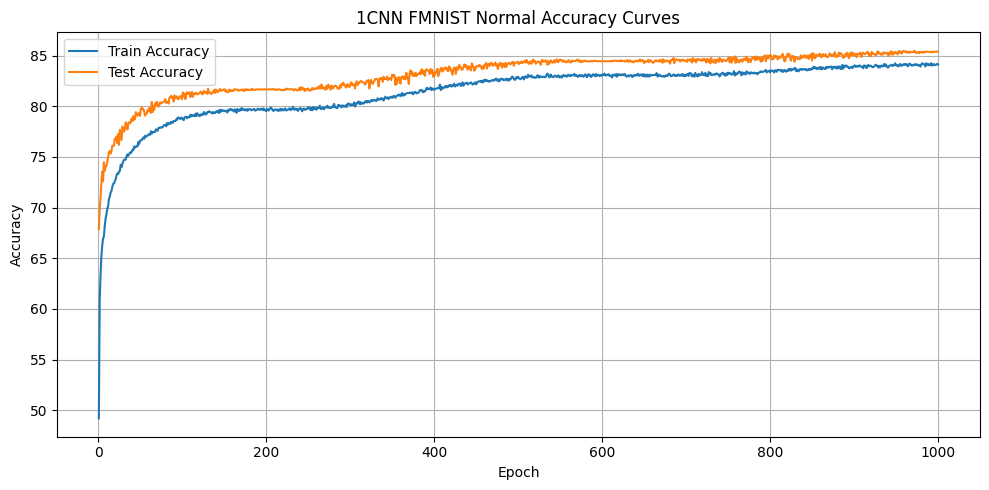

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"1CNN FMNIST Normal Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"1cnn_fmnist_normal_accuracy_curve.png")
plt.show()

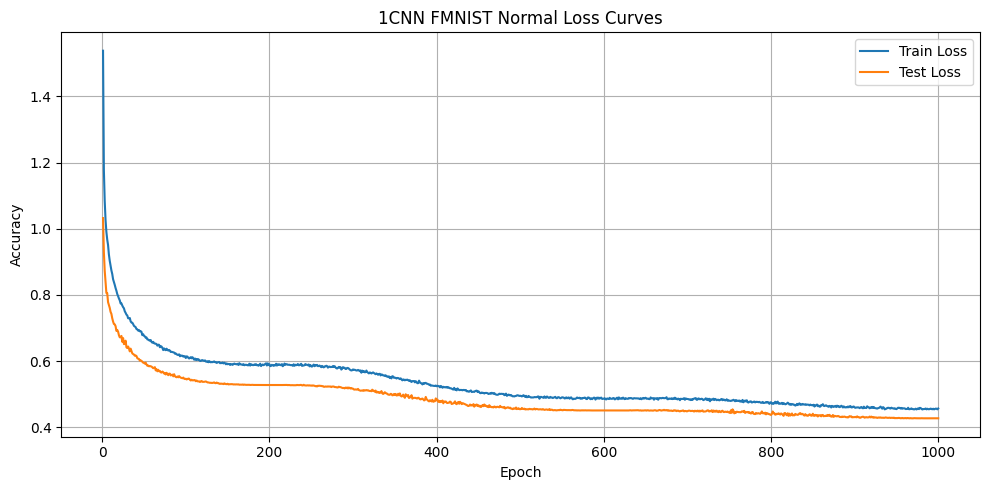

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"1CNN FMNIST Normal Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"1cnn_fmnist_normal_loss_curve.png")
plt.show()